## チュートリアル説明

本チュートリアルでは、最終的にニュースコーパスから特徴量を抽出することを目的とする。  
各章では、特徴量を抽出するにあたって、使用しているデータがどのような特性を持つかを解析し、必要に応じて正規化し、可視化する方法を説明する。  
最後の章では、自然語処理モデルであるBERT(Bidirectional Encoder Representations from Transformers)を用いて、特徴量を抽出する方法を説明する。また、抽出された特徴量をLSTMを用いて週ごとに合成する方法を説明する。

## 1.3. 基本準備
本章では、必要なライブラリーと分析用辞書などをインストールし、チュートリアルのコードを正しく利用できる環境を構築する。  
また、本チュートリアルで利用するライブラリーを宣言し、その他、チュートリアルを進めるにあたって必要な基本的な準備を行う。

In [1]:
# Google Colab環境ではGoogle Driveをマウントしてアクセスできるようにします。
import sys

# if 'google.colab' in sys.modules:
#     # Google Drive をマウントします
#     from google.colab import drive
#     mount_dir = "/content/drive"
#     drive.mount(mount_dir)

### 1.3.3. 必要なライブラリのインストール

In [2]:
# !apt update
# !apt install -y build-essential sudo mecab libmecab-dev mecab-ipadic-utf8 fonts-ipafont-gothic file
# #!pip install pandas==1.1.5 numpy==1.19.5 scattertext==0.1.0.0 wordcloud==1.8.1 torch==1.7.1 torchvision==0.8.2 transformers==4.2.2 mecab-python3==0.996.6rc1 ipadic==1.0.0 neologdn==0.4 fugashi==1.0.5 japanize-matplotlib==1.1.3 gensim==3.8.3 pyLDAvis==2.1.2
# !pip install pandas==1.1.5 numpy==1.19.5 scattertext==0.1.0.0 wordcloud==1.8.1 transformers==4.2.2 mecab-python3==0.996.6rc1 ipadic==1.0.0 neologdn==0.4 fugashi==1.0.5 japanize-matplotlib==1.1.3 gensim==3.8.3 pyLDAvis==2.1.2


# # mecab用の辞書をインストール
# !git clone https://github.com/neologd/mecab-ipadic-neologd.git --branch v0.0.7 --single-branch
# !yes yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd

### 1.3.4. ライブラリの読み込み

In [3]:
# 基本ライブラリー
import re
import os
import sys
import math
import random
import json
import joblib
import numpy as np
import pandas as pd
from scipy import stats
import string
from copy import copy
from glob import glob
from itertools import chain
import gc

# テキスト解析関連
import MeCab
import unicodedata
import neologdn

# 可視化関連
from tqdm.auto import tqdm
from IPython.display import display, display_markdown, IFrame
import scattertext as st
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import gensim
import pyLDAvis
import pyLDAvis.gensim

# ニューラルネット関連
import torch
from torch import nn
import torch.nn.functional as F
import transformers
from transformers import BertJapaneseTokenizer
from torch.utils.data import DataLoader, Dataset as _Dataset

# ノートブック上でpyLDAvisより可視化を行う場合の設定
pyLDAvis.enable_notebook()

### 1.3.6. 実行環境の確認

In [4]:
print(sys.version)

3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0]


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 1.3.7. ファイルパスの設定

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
pwd

'/home/jupyter/jpx/notebooks/handson/Chapter06'

In [7]:
base_dir =os.path.expanduser('~')
home_dir =f'{base_dir}/jpx'

dataset_dir = f"{home_dir}/data"

CONFIG = {
    'base_path': f'{dataset_dir}/workspace',
    'article_path': f'{dataset_dir}/nikkei_article.csv.gz',
    'stock_price_path': f'{dataset_dir}/stock_price.csv.gz',
    'stock_list_path': f'{dataset_dir}/stock_list.csv.gz',
    'dict_path': '/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd',
    'font_path': '/usr/share/fonts/truetype/fonts-japanese-gothic.ttf',
    }

# 1.3.10. 本番提出用のクラス作成

In [8]:
# 本番提出用のクラスを作成するため、関数の持たない基本クラスを定義する
# 下記で段階的にクラスを作り上げる
class SentimentGenerator(object):
    # 以下は使用時にビルドされる。
    # 各々に関しては、以下のチュートリアルで説明する。
    article_columns = None
    punctuation_replace_dict = None
    punctuation_remove_list = None
    device = None
    feature_extractor = None
    headline_feature_combiner_handler = None
    keywords_feature_combiner_handler = None

## 1.7.4. LSTMによる可変特徴量統合
本チュートリアルの最終モデルの評価関数は、Marketのweekly return予測することとして判定される。週ごとにデータ数が動的であるニュースデータは、それらから抽出した特徴量もその数が可変であり、それらの可変する情報を用いてモデリングする必要がある。本チュートリアルでは、週ごとのその数が可変する特徴量を一つの統合する戦略をとっている。そのため、可変長さの入力が可能なLSTMを用いて、Market returnの次の週の上げ下げの情報をラベルとして、特徴量を統合する学習を行った。

本章では、そのLSTMのモデル作成及び、学習の方法を説明し、最終的に単一特徴量として抽出する方法を説明する。

### 1.7.5. BERT特徴量ロード

In [9]:
# headline_features = pd.read_pickle(f'{CONFIG["base_path"]}/headline_features/headline_features.pkl')
# keywords_features = pd.read_pickle(f'{CONFIG["base_path"]}/keywords_features/keywords_features.pkl')


headline_features = pd.read_pickle(f'headline_features.pkl').drop_duplicates() 
keywords_features = pd.read_pickle(f'keywords_features.pkl').drop_duplicates() 

In [10]:
headline_features.head(3)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
publish_datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00+09:00,-0.440823,0.191443,-0.008909,-0.319594,-0.072300,0.466741,-0.274743,0.445048,0.498942,0.032077,...,-0.343381,0.090035,0.199363,-0.338375,0.670792,0.026400,0.632040,-0.433479,-0.011136,-0.051264
2020-01-01 00:00:00+09:00,-0.351773,-0.027478,-0.060213,-0.512602,0.254371,0.128152,0.160517,0.154172,0.151672,0.255984,...,-0.078464,0.179369,0.076657,-0.030442,-0.168868,-0.192623,0.602098,-0.076874,-0.616428,-0.406168
2020-01-01 00:00:00+09:00,-0.115327,0.017725,-0.129011,-0.553259,0.096930,0.092610,0.150430,-0.043717,-0.105239,-0.155988,...,-0.505299,0.315577,0.302115,0.032662,0.129836,-0.134002,0.500410,-0.120089,-0.640578,-0.581745


In [11]:
headline_features.shape

(204187, 768)

### Stockデータロード

In [12]:
# stock priceとstock listをロードする。
stock_price = pd.read_csv(CONFIG["stock_price_path"])
stock_list = pd.read_csv(CONFIG["stock_list_path"])

In [13]:
universe = stock_list[stock_list["universe_comp2"] == True]["Local Code"].values

In [14]:
stock_price.head(3)

,Local Code,EndOfDayQuote Date,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose,EndOfDayQuote PreviousCloseDate,EndOfDayQuote PreviousExchangeOfficialClose,EndOfDayQuote PreviousExchangeOfficialCloseDate,EndOfDayQuote ChangeFromPreviousClose,EndOfDayQuote PercentChangeFromPreviousClose,EndOfDayQuote VWAP
0,1301,2016/01/04,2800.0,2820.0,2740.0,2750.0,2750.0,32000.0,0.1,2770.0,2015/12/30,2770.0,2015/12/30,-20.0,-0.722,2778.250
1,1301,2016/01/05,2750.0,2780.0,2750.0,2760.0,2760.0,20100.0,0.1,2750.0,2016/01/04,2750.0,2016/01/04,10.0,0.364,2761.990
2,1301,2016/01/06,2760.0,2770.0,2740.0,2760.0,2760.0,15000.0,0.1,2760.0,2016/01/05,2760.0,2016/01/05,0.0,0.000,2758.867


In [15]:
stock_list.head(3)

,prediction_target,Effective Date,Local Code,Name (English),Section/Products,33 Sector(Code),33 Sector(name),17 Sector(Code),17 Sector(name),Size Code (New Index Series),Size (New Index Series),IssuedShareEquityQuote AccountingStandard,IssuedShareEquityQuote ModifyDate,IssuedShareEquityQuote IssuedShare,universe_comp2
0,True,20210331,1301,"KYOKUYO CO.,LTD.",First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,ConsolidatedJP,2021/02/05,10928283.0,True
1,True,20210331,1332,"Nippon Suisan Kaisha,Ltd.",First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,ConsolidatedJP,2021/02/05,312430277.0,True
2,True,20210331,1333,Maruha Nichiro Corporation,First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,ConsolidatedJP,2021/02/08,52656910.0,True


In [16]:
# stock_priceのデータ精製を行う。
# ラベル作成のために使用するcolumnは['EndOfDayQuote Date', 'Local Code', "EndOfDayQuote Open", "EndOfDayQuote ExchangeOfficialClose"]のみである。
# EndOfDayQuote Date: データの日付
# Local Code: 銘柄コード
# EndOfDayQuote Open: 始値
# EndOfDayQuote ExchangeOfficialClose: 終値
stock_price = stock_price[['EndOfDayQuote Date', 'Local Code', "EndOfDayQuote Open", "EndOfDayQuote ExchangeOfficialClose"]]


In [17]:
stock_price

,EndOfDayQuote Date,Local Code,EndOfDayQuote Open,EndOfDayQuote ExchangeOfficialClose
0,2016/01/04,1301,2800.0,2750.0
1,2016/01/05,1301,2750.0,2760.0
2,2016/01/06,1301,2760.0,2760.0
3,2016/01/07,1301,2740.0,2710.0
4,2016/01/08,1301,2700.0,2700.0
...,...,...,...,...
4536904,2021/04/27,9997,1206.0,1186.0
4536905,2021/04/28,9997,1178.0,1168.0
4536906,2021/04/30,9997,1165.0,1159.0
4536907,2021/05/06,9997,1150.0,1169.0


In [97]:
think_price = pd.read_csv(CONFIG["stock_price_path"])


think_price =  think_price[['EndOfDayQuote Date', 'Local Code', "EndOfDayQuote Open", "EndOfDayQuote ExchangeOfficialClose"]]





,EndOfDayQuote Date,Local Code,EndOfDayQuote Open,EndOfDayQuote ExchangeOfficialClose
0,2016/01/04,1301,2800.0,2750.0
1,2016/01/05,1301,2750.0,2760.0
2,2016/01/06,1301,2760.0,2760.0
3,2016/01/07,1301,2740.0,2710.0
4,2016/01/08,1301,2700.0,2700.0
...,...,...,...,...
4536904,2021/04/27,9997,1206.0,1186.0
4536905,2021/04/28,9997,1178.0,1168.0
4536906,2021/04/30,9997,1165.0,1159.0
4536907,2021/05/06,9997,1150.0,1169.0


In [107]:
think_price_gb = think_price.groupby('Local Code').apply(lambda x:x.iloc[-1])

In [110]:
think_price_gb.sort_values(by='EndOfDayQuote ExchangeOfficialClose', ascending=False).iloc[:30]

,EndOfDayQuote Date,Local Code,EndOfDayQuote Open,EndOfDayQuote ExchangeOfficialClose
Local Code,,,,
9983,2021/05/07,9983,92880.0,92110.0
6273,2021/05/07,6273,63600.0,63900.0
7974,2021/05/07,7974,60910.0,60410.0
6861,2021/05/07,6861,53590.0,53290.0
8035,2021/05/07,8035,49200.0,49910.0
4628,2021/05/07,4628,40250.0,39800.0
6146,2021/05/07,6146,35200.0,35300.0
6532,2021/05/07,6532,31850.0,33050.0
5217,2021/05/07,5217,0.0,30600.0


In [18]:
headline_features

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
publish_datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00+09:00,-0.440823,0.191443,-0.008909,-0.319594,-0.072300,0.466741,-0.274743,0.445048,0.498942,0.032077,...,-0.343381,0.090035,0.199363,-0.338375,0.670792,0.026400,0.632040,-0.433479,-0.011136,-0.051264
2020-01-01 00:00:00+09:00,-0.351773,-0.027478,-0.060213,-0.512602,0.254371,0.128152,0.160517,0.154172,0.151672,0.255984,...,-0.078464,0.179369,0.076657,-0.030442,-0.168868,-0.192623,0.602098,-0.076874,-0.616428,-0.406168
2020-01-01 00:00:00+09:00,-0.115327,0.017725,-0.129011,-0.553259,0.096930,0.092610,0.150430,-0.043717,-0.105239,-0.155988,...,-0.505299,0.315577,0.302115,0.032662,0.129836,-0.134002,0.500410,-0.120089,-0.640578,-0.581745
2020-01-01 00:00:00+09:00,-0.082643,0.015849,-0.261205,-0.709782,0.134204,-0.275223,-0.240528,-0.008686,-0.325322,-0.086244,...,0.080132,0.278928,-0.055144,-0.343607,0.222592,-0.453482,0.727790,-0.652582,-0.290925,-0.652478
2020-01-01 00:00:00+09:00,-0.362248,0.274889,-0.302156,-0.552606,0.304639,0.032461,-0.030220,-0.024220,-0.431887,-0.063781,...,-0.233730,0.355484,0.347163,-0.408047,0.232971,-0.352596,0.387620,-0.666730,0.058338,-0.163645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26 06:21:42+09:00,-0.131959,0.322454,0.072140,-0.160362,-0.565499,-0.507368,-0.519777,-0.150441,-0.792407,-0.138985,...,0.029282,0.516906,0.786607,-0.026618,0.149767,0.300387,0.362182,0.091090,-0.098043,-0.275878
2021-04-26 06:42:34+09:00,-0.481320,-0.080677,0.522971,-0.384430,-0.411017,0.215466,-0.058978,-0.006510,-0.074215,0.528735,...,-0.124171,0.384452,0.058012,0.052157,-0.129110,-0.226407,1.035842,-0.559187,-0.353305,0.231397
2021-04-26 07:42:10+09:00,-0.292841,-0.470984,0.208906,-0.274291,-0.511130,-0.156421,-0.122630,0.129252,0.027618,0.014042,...,0.383980,0.288247,-0.207509,0.388325,0.448128,-0.246753,0.555154,0.012148,0.029467,-0.339523


In [19]:

# それぞれのcolumn名をわかりやすく変更する
stock_price = stock_price.rename(columns={
    'EndOfDayQuote Date': 'date',
    'Local Code': 'asset',
    'EndOfDayQuote Open': 'open',
    'EndOfDayQuote ExchangeOfficialClose': 'close',
})

# データごとにindex形式が異なると大変扱いにくい。下記のコードより特徴量と同様のindexの形式を変更する。
# pd.to_datetimeより、string形式の日付をpd.Timestamp形式に変換する
# pd.Timestamp形式をpd.DatetimeIndex形式に変更し、time zoneをheadline_featuresと同様に設定する。
# この際、headline_featuresとkeywords_featuresはarticlesのindexを使用しているため、timezoneが一致している。どちらを用いても良い。
stock_price['date'] = pd.to_datetime(stock_price['date'])
stock_price['date'] = pd.DatetimeIndex(stock_price['date']).tz_localize(headline_features.index.tz)





In [20]:


stock_price_duplicates = stock_price[stock_price.duplicated(subset=['date', 'asset'])]

In [21]:
stock_price_drop_duplicates = stock_price[~stock_price.index.isin(stock_price_duplicates.index)]

In [22]:
# indexを['date', 'asset']順のpd.MultiIndex形式として設定する。
stock_price = stock_price_drop_duplicates.set_index(['date', 'asset']).sort_index()

In [23]:
stock_price

open   close
date                      asset                
2016-01-04 00:00:00+09:00 1301   2800.0  2750.0
                          1332    696.0   683.0
                          1333   2124.0  2036.0
                          1352   1300.0  1280.0
                          1376   1195.0  1200.0
...                                 ...     ...
2021-05-07 00:00:00+09:00 9993   1729.0  1709.0
                          9994   2337.0  2335.0
                          9995    431.0   429.0
                          9996   1500.0  1500.0
                          9997   1155.0  1194.0

[4527354 rows x 2 columns]

In [24]:
# unstack()より銘柄情報をcolumnに移動させる。
stock_price = stock_price.unstack()

# 今回使用するデータは2020年以降のデータであるので、2020年以前のデータを切り捨てる。
stock_price = stock_price['2020-01-01':]

# 確認する
display(stock_price.head())

open                                             \
asset                        1301   1332    1333   1352 1375    1376    1377   
date                                                                           
2020-01-06 00:00:00+09:00  2860.0  639.0  2770.0  864.0  NaN  1440.0  3635.0   
2020-01-07 00:00:00+09:00  2864.0  634.0  2725.0  932.0  NaN  1390.0  3715.0   
2020-01-08 00:00:00+09:00  2892.0  624.0  2714.0  903.0  NaN  1439.0  3635.0   
2020-01-09 00:00:00+09:00  2911.0  628.0  2734.0  894.0  NaN  1420.0  3725.0   
2020-01-10 00:00:00+09:00  2940.0  627.0  2765.0  894.0  NaN  1420.0  3570.0   

                                                  ...   close                  \
asset                        1379   1380    1381  ...    9986    9987    9989   
date                                              ...                           
2020-01-06 00:00:00+09:00  1956.0  816.0  2389.0  ...  1485.0  4335.0  3915.0   
2020-01-07 00:00:00+09:00  1965.0  818.0  2370.0  ...  1490.0  4430.0  3995.0   
2020-01-08 00:00:00+09:00  1943.0  820.0  2357.0  ...  1481.0  4400.0  3940.0   
2020-01-09 00:00:00+09:00  1948.0  818.0  2360.0  ...  1490.0  4440.0  4040.0   
2020-01-10 00:00:00+09:00  1971.0  819.0  2368.0  ...  1490.0  4470.0  3995.0   

                                                                                
asset                       9990    9991    9993    9994   9995    9996   9997  
date                                                                            
2020-01-06 00:00:00+09:00  922.0  1098.0  1700.0  2271.0  457.0  1671.0  703.0  
2020-01-07 00:00:00+09:00  924.0  1113.0  1713.0  2296.0  460.0  1674.0  706.0  
2020-01-08 00:00:00+09:00  911.0  1111.0  1689.0  2307.0  458.0  1675.0  689.0  
2020-01-09 00:00:00+09:00  927.0  1135.0  1699.0  2308.0  459.0  1700.0  695.0  
2020-01-10 00:00:00+09:00  921.0  1129.0  1697.0  2280.0  468.0  1735.0  696.0  

[5 rows x 7422 columns]

In [25]:
# stock_listデータから2020年12月末日時点での株式発行数の情報のみを取得する。
# 使用するcolumnは、['Local Code', 'IssuedShareEquityQuote IssuedShare']である。
# Local code: 銘柄コード
# IssuedShareEquityQuote IssuedShare: 発行株式数
stock_list = stock_list[['Local Code', 'IssuedShareEquityQuote IssuedShare']]

# columns名をわかりやすく変更する
stock_list = stock_list.rename(
    columns={
        'Local Code': 'asset',
        'IssuedShareEquityQuote IssuedShare': 'shares'
    }
)

# assetをindexとして設定する
shares = stock_list.set_index('asset')['shares']

# 確認する
display(shares)

asset
1301     10928283.0
1332    312430277.0
1333     52656910.0
1352      8379000.0
1375     39850000.0
           ...     
9993     10960825.0
9994     10847870.0
9995     26426800.0
9996      9152640.0
9997     97244472.0
Name: shares, Length: 3711, dtype: float64

### 使用する銘柄選定

本章では、以下の条件に従い、マーケットのリターンを計算する際に用いる銘柄を選定する。

1. 2020年12月末日時点で、東京証券取引所に上場していること。
2. 2020年12月末日時点で、時価総額が200億を上回っていること。

上の条件を満たす銘柄を選ぶため、以下のロジックに従う。
1. 12月末日時点で価格情報が存在するものを上場しているとみなす。
2. 12月末日時点での株式発行数 * 終値から時価総額を計算し、200億円未満のものを切り捨てる。

In [26]:
# # 条件１「2020年12月末日時点で、東京証券取引所に上場していること」に該当する銘柄を取得する。
# # まず、indexの最終日を取得する。
# last_date = stock_price.index[-1]

# # 2020年の末日が、最終日であることがわかる。
# display(last_date)

# stock_price['close'].columns

# universe_condition_1 ^ stock_price['close'].columns

# # 2020年の末日時点での終値が存在する銘柄を取得する。
# universe_condition_1 = stock_price.xs(last_date)["close"].dropna().index

# # 条件一に該当する銘柄数を確認する。
# print(f'number_of_assets: {len(universe_condition_1)}/{len(stock_price["close"].columns)}')

# # 条件２「2020年12月末日時点で、時価総額が200億を上回っていること」に該当する銘柄を取得する。
# # まず、株式発行数 * 終値から時価総額を計算する。(単位: 円)
# marketcap = (stock_price.xs(last_date)['close'] * shares)

# # 確認する
# display(marketcap)

# # 時価総額が200億円未満のものを切り捨てる
# universe_condition_2 = marketcap[marketcap >= 20000000000].index

# # 条件一に該当する銘柄数を確認する。
# print(f'number_of_assets: {len(universe_condition_2)}/{len(stock_price["close"].columns)}')



# universe

# # 上の二つの条件を合成し、universeを設定する。
# universe = universe_condition_1 & universe_condition_2

# # universeをcsvでstoreしておきます。
# universe.to_series().rename('universe').to_frame().to_csv('universe.csv')

# # 条件に該当する銘柄数を確認する。
# print(f'number_of_assets: {len(universe)}/{len(stock_price["close"].columns)}')

In [27]:
# 選定された銘柄のみの価格情報に精製する。
stock_price = stock_price[[column for column in stock_price.columns if column[-1] in universe]]

In [28]:
stock_price

open                                         \
asset                        1301   1332    1333    1375    1377    1379   
date                                                                       
2020-01-06 00:00:00+09:00  2860.0  639.0  2770.0     NaN  3635.0  1956.0   
2020-01-07 00:00:00+09:00  2864.0  634.0  2725.0     NaN  3715.0  1965.0   
2020-01-08 00:00:00+09:00  2892.0  624.0  2714.0     NaN  3635.0  1943.0   
2020-01-09 00:00:00+09:00  2911.0  628.0  2734.0     NaN  3725.0  1948.0   
2020-01-10 00:00:00+09:00  2940.0  627.0  2765.0     NaN  3570.0  1971.0   
...                           ...    ...     ...     ...     ...     ...   
2021-04-27 00:00:00+09:00  2940.0  501.0  2452.0  1954.0  3935.0  1996.0   
2021-04-28 00:00:00+09:00  2900.0  505.0  2464.0  1919.0  3910.0  2004.0   
2021-04-30 00:00:00+09:00  2913.0  507.0  2471.0  1914.0  3865.0  1987.0   
2021-05-06 00:00:00+09:00  2947.0  516.0  2535.0  1923.0  3885.0  2000.0   
2021-05-07 00:00:00+09:00  2998.0  532.0  2630.0  1988.0  3875.0  2015.0   

                                                           ...   close  \
asset                        1407    1413    1414    1417  ...    9962   
date                                                       ...           
2020-01-06 00:00:00+09:00  1067.5  2173.0  4485.0  1642.0  ...  2704.0   
2020-01-07 00:00:00+09:00  1079.3  2130.0  4610.0  1658.0  ...  2765.0   
2020-01-08 00:00:00+09:00  1087.0  2145.0  4555.0  1662.0  ...  2697.0   
2020-01-09 00:00:00+09:00  1082.2  2150.0  4680.0  1704.0  ...  2806.0   
2020-01-10 00:00:00+09:00  1054.4  2180.0  4675.0  1714.0  ...  2908.0   
...                           ...     ...     ...     ...  ...     ...   
2021-04-27 00:00:00+09:00  3705.0  2575.0  4705.0  1771.0  ...  3105.0   
2021-04-28 00:00:00+09:00  3665.0  2540.0  4680.0  1803.0  ...  3140.0   
2021-04-30 00:00:00+09:00  3630.0  2531.0  4615.0  1783.0  ...  3080.0   
2021-05-06 00:00:00+09:00  3505.0  2599.0  4545.0  1760.0  ...  3100.0   
2021-05-07 00:00:00+09:00  3415.0  2554.0  4555.0  1762.0  ...  3260.0   

                                                                             \
asset                        9974    9979     9983     9984    9987    9989   
date                                                                          
2020-01-06 00:00:00+09:00  5490.0  1663.0  63050.0   4569.0  4335.0  3915.0   
2020-01-07 00:00:00+09:00  5710.0  1685.0  63250.0   4646.0  4430.0  3995.0   
2020-01-08 00:00:00+09:00  5790.0  1680.0  62080.0   4583.0  4400.0  3940.0   
2020-01-09 00:00:00+09:00  5810.0  1690.0  63760.0   4797.0  4440.0  4040.0   
2020-01-10 00:00:00+09:00  5640.0  1679.0  61990.0   4878.0  4470.0  3995.0   
...                           ...     ...      ...      ...     ...     ...   
2021-04-27 00:00:00+09:00  5850.0   988.0  89340.0  10040.0  3960.0  3800.0   
2021-04-28 00:00:00+09:00  5780.0   989.0  89730.0   9891.0  3950.0  3725.0   
2021-04-30 00:00:00+09:00  5790.0  1001.0  89710.0   9885.0  3935.0  3725.0   
2021-05-06 00:00:00+09:00  5840.0  1001.0  92790.0  10040.0  4010.0  3770.0   
2021-05-07 00:00:00+09:00  5870.0  1011.0  92110.0  10000.0  4005.0  3820.0   

                                                   
asset                        9991    9994    9997  
date                                               
2020-01-06 00:00:00+09:00  1098.0  2271.0   703.0  
2020-01-07 00:00:00+09:00  1113.0  2296.0   706.0  
2020-01-08 00:00:00+09:00  1111.0  2307.0   689.0  
2020-01-09 00:00:00+09:00  1135.0  2308.0   695.0  
2020-01-10 00:00:00+09:00  1129.0  2280.0   696.0  
...                           ...     ...     ...  
2021-04-27 00:00:00+09:00   917.0  2324.0  1186.0  
2021-04-28 00:00:00+09:00   910.0  2336.0  1168.0  
2021-04-30 00:00:00+09:00   893.0  2315.0  1159.0  
2021-05-06 00:00:00+09:00   906.0  2315.0  1169.0  
2021-05-07 00:00:00+09:00   919.0  2335.0  1194.0  

[326 rows x 3558 columns]

### 1.7.6. 週ごとにグループされた特徴量とラベルの作成

In [29]:
# 各週ごとの特徴量を統合するためには、週ごとの全ての特徴量をグループすると扱いやすくなる。
# ここでは、週ごとに特徴量とプライス情報をグループする方法を説明する。
# また、週ごとのプライス情報をグループし、weekly returnを計算し、ラベルを作成する方法を説明する。
@classmethod
def _build_weekly_group(cls, df):
    # index情報から、(year, week)の情報を得る。
    return pd.Series(list(zip(df.index.year, df.index.week)), index=df.index)

# SentimentGeneratorに定義したclassmethodを追加する
SentimentGenerator._build_weekly_group = _build_weekly_group

# 特徴量に適用してみる
display_markdown('#### features', raw=True)
features = headline_features
weekly_group = SentimentGenerator._build_weekly_group(df=features)
display(weekly_group.head(3))
display(weekly_group.tail(3))

# プライスに適用してみる。
# stock priceの2020年の1週目は、データが存在しないため、2020年の２週目から存在することがわかる。
# これらのindexをマッチさせることは後ほど説明する。
display_markdown('#### stock price', raw=True)
weekly_group = SentimentGenerator._build_weekly_group(stock_price)
display(weekly_group.head(3))
display(weekly_group.tail(3))

#### features

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  import sys


publish_datetime
2020-01-01 00:00:00+09:00    (2020, 1)
2020-01-01 00:00:00+09:00    (2020, 1)
2020-01-01 00:00:00+09:00    (2020, 1)
dtype: object

publish_datetime
2021-04-26 07:42:10+09:00    (2021, 17)
2021-04-26 08:02:15+09:00    (2021, 17)
2021-04-26 08:06:04+09:00    (2021, 17)
dtype: object

#### stock price

date
2020-01-06 00:00:00+09:00    (2020, 2)
2020-01-07 00:00:00+09:00    (2020, 2)
2020-01-08 00:00:00+09:00    (2020, 2)
dtype: object

date
2021-04-30 00:00:00+09:00    (2021, 17)
2021-05-06 00:00:00+09:00    (2021, 18)
2021-05-07 00:00:00+09:00    (2021, 18)
dtype: object

In [30]:
# (2021, 53)が入っている
set(weekly_group.values.tolist())

{(2020, 2),
 (2020, 3),
 (2020, 4),
 (2020, 5),
 (2020, 6),
 (2020, 7),
 (2020, 8),
 (2020, 9),
 (2020, 10),
 (2020, 11),
 (2020, 12),
 (2020, 13),
 (2020, 14),
 (2020, 15),
 (2020, 16),
 (2020, 17),
 (2020, 18),
 (2020, 19),
 (2020, 20),
 (2020, 21),
 (2020, 22),
 (2020, 23),
 (2020, 24),
 (2020, 25),
 (2020, 26),
 (2020, 27),
 (2020, 28),
 (2020, 29),
 (2020, 30),
 (2020, 31),
 (2020, 32),
 (2020, 33),
 (2020, 34),
 (2020, 35),
 (2020, 36),
 (2020, 37),
 (2020, 38),
 (2020, 39),
 (2020, 40),
 (2020, 41),
 (2020, 42),
 (2020, 43),
 (2020, 44),
 (2020, 45),
 (2020, 46),
 (2020, 47),
 (2020, 48),
 (2020, 49),
 (2020, 50),
 (2020, 51),
 (2020, 52),
 (2020, 53),
 (2021, 1),
 (2021, 2),
 (2021, 3),
 (2021, 4),
 (2021, 5),
 (2021, 6),
 (2021, 7),
 (2021, 8),
 (2021, 9),
 (2021, 10),
 (2021, 11),
 (2021, 12),
 (2021, 13),
 (2021, 14),
 (2021, 15),
 (2021, 16),
 (2021, 17),
 (2021, 18)}

In [31]:
weekly_group

date
2020-01-06 00:00:00+09:00     (2020, 2)
2020-01-07 00:00:00+09:00     (2020, 2)
2020-01-08 00:00:00+09:00     (2020, 2)
2020-01-09 00:00:00+09:00     (2020, 2)
2020-01-10 00:00:00+09:00     (2020, 2)
                                ...    
2021-04-27 00:00:00+09:00    (2021, 17)
2021-04-28 00:00:00+09:00    (2021, 17)
2021-04-30 00:00:00+09:00    (2021, 17)
2021-05-06 00:00:00+09:00    (2021, 18)
2021-05-07 00:00:00+09:00    (2021, 18)
Length: 326, dtype: object

In [32]:
# 特徴量を週ごとにグループ化してみる
#weekly_group = SentimentGenerator._build_weekly_group(df=features)
features = features.groupby(weekly_group).apply(lambda x: x[:])

# 週の情報がindexのlevel 0に付与され、グループされていることがわかる。
features.head(3)

0         1         2         3    \
          publish_datetime                                                    
(2020, 2) 2020-01-06 00:00:00+09:00 -0.289154  0.097129 -0.059530 -0.102498   
          2020-01-06 00:00:00+09:00  0.201710  0.145570  0.294023 -0.183763   
          2020-01-06 00:00:00+09:00 -0.253009  0.073220 -0.223516 -0.632563   

                                          4         5         6         7    \
          publish_datetime                                                    
(2020, 2) 2020-01-06 00:00:00+09:00 -0.018000 -0.057688 -0.064568 -0.189535   
          2020-01-06 00:00:00+09:00 -0.220444  0.247257  0.168728 -0.211755   
          2020-01-06 00:00:00+09:00  0.003297  0.303431 -0.433840 -0.114185   

                                          8         9    ...       758  \
          publish_datetime                               ...             
(2020, 2) 2020-01-06 00:00:00+09:00  0.188820  0.170921  ...  0.222269   
          2020-01-06 00:00:00+09:00 -0.093412  0.282540  ... -0.089245   
          2020-01-06 00:00:00+09:00 -0.077887  0.419299  ... -0.022604   

                                          759       760       761       762  \
          publish_datetime                                                    
(2020, 2) 2020-01-06 00:00:00+09:00  0.691915  0.214906 -0.071773 -0.097542   
          2020-01-06 00:00:00+09:00  0.680741  0.434911  0.266660 -0.146624   
          2020-01-06 00:00:00+09:00  0.683445  0.407548  0.119134 -0.045806   

                                          763       764       765       766  \
          publish_datetime                                                    
(2020, 2) 2020-01-06 00:00:00+09:00 -0.054367  0.527780 -0.079704 -0.389090   
          2020-01-06 00:00:00+09:00 -0.105315  1.021949 -0.450021 -0.101502   
          2020-01-06 00:00:00+09:00  0.199645  0.416823 -0.185465 -0.164332   

                                          767  
          publish_datetime                     
(2020, 2) 2020-01-06 00:00:00+09:00  0.316290  
          2020-01-06 00:00:00+09:00 -0.116936  
          2020-01-06 00:00:00+09:00 -0.041801  

[3 rows x 768 columns]

In [33]:
set(weekly_group.values.tolist())

{(2020, 2),
 (2020, 3),
 (2020, 4),
 (2020, 5),
 (2020, 6),
 (2020, 7),
 (2020, 8),
 (2020, 9),
 (2020, 10),
 (2020, 11),
 (2020, 12),
 (2020, 13),
 (2020, 14),
 (2020, 15),
 (2020, 16),
 (2020, 17),
 (2020, 18),
 (2020, 19),
 (2020, 20),
 (2020, 21),
 (2020, 22),
 (2020, 23),
 (2020, 24),
 (2020, 25),
 (2020, 26),
 (2020, 27),
 (2020, 28),
 (2020, 29),
 (2020, 30),
 (2020, 31),
 (2020, 32),
 (2020, 33),
 (2020, 34),
 (2020, 35),
 (2020, 36),
 (2020, 37),
 (2020, 38),
 (2020, 39),
 (2020, 40),
 (2020, 41),
 (2020, 42),
 (2020, 43),
 (2020, 44),
 (2020, 45),
 (2020, 46),
 (2020, 47),
 (2020, 48),
 (2020, 49),
 (2020, 50),
 (2020, 51),
 (2020, 52),
 (2020, 53),
 (2021, 1),
 (2021, 2),
 (2021, 3),
 (2021, 4),
 (2021, 5),
 (2021, 6),
 (2021, 7),
 (2021, 8),
 (2021, 9),
 (2021, 10),
 (2021, 11),
 (2021, 12),
 (2021, 13),
 (2021, 14),
 (2021, 15),
 (2021, 16),
 (2021, 17),
 (2021, 18)}

In [34]:
#features.loc[(2020, 1), :]
features

0         1         2         3    \
           publish_datetime                                                    
(2020, 2)  2020-01-06 00:00:00+09:00 -0.289154  0.097129 -0.059530 -0.102498   
           2020-01-06 00:00:00+09:00  0.201710  0.145570  0.294023 -0.183763   
           2020-01-06 00:00:00+09:00 -0.253009  0.073220 -0.223516 -0.632563   
           2020-01-06 00:00:00+09:00 -0.067347  0.255860 -0.006545 -0.698507   
           2020-01-07 00:00:00+09:00 -0.440674  0.201770 -0.111534 -0.280296   
...                                        ...       ...       ...       ...   
(2021, 16) 2021-04-21 00:00:00+09:00 -0.074304 -0.147251 -0.126704 -0.191435   
           2021-04-22 00:00:00+09:00 -0.188217  0.065564 -0.208851 -0.274145   
           2021-04-23 00:00:00+09:00 -0.125396 -0.228193 -0.355004 -0.194184   
           2021-04-23 00:00:00+09:00 -0.281854  0.144241 -0.196552 -0.088808   
           2021-04-23 00:00:00+09:00 -0.447602  0.700280 -0.178380 -0.442765   

                                           4         5         6         7    \
           publish_datetime                                                    
(2020, 2)  2020-01-06 00:00:00+09:00 -0.018000 -0.057688 -0.064568 -0.189535   
           2020-01-06 00:00:00+09:00 -0.220444  0.247257  0.168728 -0.211755   
           2020-01-06 00:00:00+09:00  0.003297  0.303431 -0.433840 -0.114185   
           2020-01-06 00:00:00+09:00  0.007440  0.154309 -0.050523  0.141681   
           2020-01-07 00:00:00+09:00 -0.329830  0.091601 -0.333430 -0.401159   
...                                        ...       ...       ...       ...   
(2021, 16) 2021-04-21 00:00:00+09:00 -0.279710  0.245431 -0.716217 -0.018153   
           2021-04-22 00:00:00+09:00 -0.295686  0.442933  0.165149  0.104354   
           2021-04-23 00:00:00+09:00  0.505608  0.601193 -0.590609 -0.210228   
           2021-04-23 00:00:00+09:00 -0.236635  0.570697 -0.039251 -0.145481   
           2021-04-23 00:00:00+09:00 -0.010382  0.629423 -0.485379  0.324430   

                                           8         9    ...       758  \
           publish_datetime                               ...             
(2020, 2)  2020-01-06 00:00:00+09:00  0.188820  0.170921  ...  0.222269   
           2020-01-06 00:00:00+09:00 -0.093412  0.282540  ... -0.089245   
           2020-01-06 00:00:00+09:00 -0.077887  0.419299  ... -0.022604   
           2020-01-06 00:00:00+09:00 -0.756877  0.574499  ... -0.231336   
           2020-01-07 00:00:00+09:00 -0.252863  0.419047  ... -0.119913   
...                                        ...       ...  ...       ...   
(2021, 16) 2021-04-21 00:00:00+09:00  0.263349  0.018361  ... -0.048587   
           2021-04-22 00:00:00+09:00 -0.113868  0.517309  ...  0.059444   
           2021-04-23 00:00:00+09:00  0.304487  0.047742  ...  0.004235   
           2021-04-23 00:00:00+09:00  0.242049  0.278345  ...  0.438591   
           2021-04-23 00:00:00+09:00  0.095042 -0.174468  ...  0.391631   

                                           759       760       761       762  \
           publish_datetime                                                    
(2020, 2)  2020-01-06 00:00:00+09:00  0.691915  0.214906 -0.071773 -0.097542   
           2020-01-06 00:00:00+09:00  0.680741  0.434911  0.266660 -0.146624   
           2020-01-06 00:00:00+09:00  0.683445  0.407548  0.119134 -0.045806   
           2020-01-06 00:00:00+09:00  0.619700 -0.246283  0.070449  0.146932   
           2020-01-07 00:00:00+09:00  0.689343  0.413203 -0.143758 -0.055751   
...                                        ...       ...       ...       ...   
(2021, 16) 2021-04-21 00:00:00+09:00  0.228285  0.273668 -0.219768  0.218754   
           2021-04-22 00:00:00+09:00  0.694781  0.137739  0.128793  0.036377   
           2021-04-23 00:00:00+09:00  0.462783  0.409537  0.005886  0.060186   
           2021-04-23 00:00:00+09:00  0.384571 -0.157137  0.505981  0.437189   
           2021-04-23 00:

In [35]:
# trainとtestを区切る週をboundary_weekとして設定し、train用に用いられる特徴量と、test用に用いられる特徴量を区切る。
boundary_week = (2021, 14)

train_features = features[features.index.get_level_values(0) <= boundary_week]
test_features = features[features.index.get_level_values(0) > boundary_week]

display_markdown('#### train_features', raw=True)
display(train_features.head(3))
display(train_features.tail(3))

display_markdown('#### test_features', raw=True)
display(test_features.head(3))
display(test_features.tail(3))

#### train_features

0         1         2         3    \
          publish_datetime                                                    
(2020, 2) 2020-01-06 00:00:00+09:00 -0.289154  0.097129 -0.059530 -0.102498   
          2020-01-06 00:00:00+09:00  0.201710  0.145570  0.294023 -0.183763   
          2020-01-06 00:00:00+09:00 -0.253009  0.073220 -0.223516 -0.632563   

                                          4         5         6         7    \
          publish_datetime                                                    
(2020, 2) 2020-01-06 00:00:00+09:00 -0.018000 -0.057688 -0.064568 -0.189535   
          2020-01-06 00:00:00+09:00 -0.220444  0.247257  0.168728 -0.211755   
          2020-01-06 00:00:00+09:00  0.003297  0.303431 -0.433840 -0.114185   

                                          8         9    ...       758  \
          publish_datetime                               ...             
(2020, 2) 2020-01-06 00:00:00+09:00  0.188820  0.170921  ...  0.222269   
          2020-01-06 00:00:00+09:00 -0.093412  0.282540  ... -0.089245   
          2020-01-06 00:00:00+09:00 -0.077887  0.419299  ... -0.022604   

                                          759       760       761       762  \
          publish_datetime                                                    
(2020, 2) 2020-01-06 00:00:00+09:00  0.691915  0.214906 -0.071773 -0.097542   
          2020-01-06 00:00:00+09:00  0.680741  0.434911  0.266660 -0.146624   
          2020-01-06 00:00:00+09:00  0.683445  0.407548  0.119134 -0.045806   

                                          763       764       765       766  \
          publish_datetime                                                    
(2020, 2) 2020-01-06 00:00:00+09:00 -0.054367  0.527780 -0.079704 -0.389090   
          2020-01-06 00:00:00+09:00 -0.105315  1.021949 -0.450021 -0.101502   
          2020-01-06 00:00:00+09:00  0.199645  0.416823 -0.185465 -0.164332   

                                          767  
          publish_datetime                     
(2020, 2) 2020-01-06 00:00:00+09:00  0.316290  
          2020-01-06 00:00:00+09:00 -0.116936  
          2020-01-06 00:00:00+09:00 -0.041801  

[3 rows x 768 columns]

0         1         2         3    \
           publish_datetime                                                    
(2021, 14) 2021-04-08 00:00:00+09:00 -0.171259  0.263223 -0.250318  0.022049   
           2021-04-08 00:00:00+09:00 -0.412282  0.386228  0.341536 -0.181520   
           2021-04-09 00:00:00+09:00 -0.366293  0.725414 -0.083247 -0.562904   

                                           4         5         6         7    \
           publish_datetime                                                    
(2021, 14) 2021-04-08 00:00:00+09:00 -0.017166 -0.148344  0.043742 -0.074002   
           2021-04-08 00:00:00+09:00 -0.796644  0.301068 -0.544840 -0.015757   
           2021-04-09 00:00:00+09:00 -0.036988  0.286087 -0.378585  0.333717   

                                           8         9    ...       758  \
           publish_datetime                               ...             
(2021, 14) 2021-04-08 00:00:00+09:00 -0.102968  0.427386  ... -0.062933   
           2021-04-08 00:00:00+09:00  0.278363  0.733338  ... -0.017801   
           2021-04-09 00:00:00+09:00 -0.170858  0.415252  ... -0.088110   

                                           759       760       761       762  \
           publish_datetime                                                    
(2021, 14) 2021-04-08 00:00:00+09:00  0.769190  0.129373 -0.083450  0.232963   
           2021-04-08 00:00:00+09:00  0.139076  0.332136 -0.129993  0.461574   
           2021-04-09 00:00:00+09:00  0.507593  0.103682  0.050417  0.140105   

                                           763       764       765       766  \
           publish_datetime                                                    
(2021, 14) 2021-04-08 00:00:00+09:00 -0.309581  0.455311 -0.140154 -0.258127   
           2021-04-08 00:00:00+09:00  0.469430  0.805229 -0.479800 -0.445565   
           2021-04-09 00:00:00+09:00 -0.013123  0.535946 -0.395489 -0.249789   

                                           767  
           publish_datetime                     
(2021, 14) 2021-04-08 00:00:00+09:00  0.067903  
           2021-04-08 00:00:00+09:00 -0.466076  
           2021-04-09 00:00:00+09:00 -0.217547  

[3 rows x 768 columns]

#### test_features

0         1         2         3    \
           publish_datetime                                                    
(2021, 15) 2021-04-12 00:00:00+09:00 -0.146865 -0.113495  0.037609 -0.368194   
           2021-04-13 00:00:00+09:00 -0.205780 -0.001318 -0.373125 -0.360534   
           2021-04-13 00:00:00+09:00 -0.166741  0.234856  0.033130 -0.248867   

                                           4         5         6         7    \
           publish_datetime                                                    
(2021, 15) 2021-04-12 00:00:00+09:00  0.141926  0.386487 -0.158216 -0.002425   
           2021-04-13 00:00:00+09:00 -0.356638  0.071630 -0.412982  0.539865   
           2021-04-13 00:00:00+09:00 -0.643106 -0.407057 -0.222240 -0.139765   

                                           8         9    ...       758  \
           publish_datetime                               ...             
(2021, 15) 2021-04-12 00:00:00+09:00 -0.190488  0.550203  ... -0.086914   
           2021-04-13 00:00:00+09:00  0.241715 -0.181550  ...  0.377711   
           2021-04-13 00:00:00+09:00 -0.257530  0.257521  ... -0.467112   

                                           759       760       761       762  \
           publish_datetime                                                    
(2021, 15) 2021-04-12 00:00:00+09:00  0.043712  0.401764 -0.570999  0.488694   
           2021-04-13 00:00:00+09:00 -0.272971  0.218357  0.233308  0.364688   
           2021-04-13 00:00:00+09:00  0.065325  0.091396 -0.176056  0.633441   

                                           763       764       765       766  \
           publish_datetime                                                    
(2021, 15) 2021-04-12 00:00:00+09:00  0.023279  0.513536 -0.291882 -0.385967   
           2021-04-13 00:00:00+09:00  0.270589  0.522122 -0.368055 -0.036030   
           2021-04-13 00:00:00+09:00 -0.171471  0.443589 -0.606418 -0.012341   

                                           767  
           publish_datetime                     
(2021, 15) 2021-04-12 00:00:00+09:00 -0.139143  
           2021-04-13 00:00:00+09:00 -0.635520  
           2021-04-13 00:00:00+09:00  0.025279  

[3 rows x 768 columns]

0         1         2         3    \
           publish_datetime                                                    
(2021, 16) 2021-04-23 00:00:00+09:00 -0.125396 -0.228193 -0.355004 -0.194184   
           2021-04-23 00:00:00+09:00 -0.281854  0.144241 -0.196552 -0.088808   
           2021-04-23 00:00:00+09:00 -0.447602  0.700280 -0.178380 -0.442765   

                                           4         5         6         7    \
           publish_datetime                                                    
(2021, 16) 2021-04-23 00:00:00+09:00  0.505608  0.601193 -0.590609 -0.210228   
           2021-04-23 00:00:00+09:00 -0.236635  0.570697 -0.039251 -0.145481   
           2021-04-23 00:00:00+09:00 -0.010382  0.629423 -0.485379  0.324430   

                                           8         9    ...       758  \
           publish_datetime                               ...             
(2021, 16) 2021-04-23 00:00:00+09:00  0.304487  0.047742  ...  0.004235   
           2021-04-23 00:00:00+09:00  0.242049  0.278345  ...  0.438591   
           2021-04-23 00:00:00+09:00  0.095042 -0.174468  ...  0.391631   

                                           759       760       761       762  \
           publish_datetime                                                    
(2021, 16) 2021-04-23 00:00:00+09:00  0.462783  0.409537  0.005886  0.060186   
           2021-04-23 00:00:00+09:00  0.384571 -0.157137  0.505981  0.437189   
           2021-04-23 00:00:00+09:00  0.523749 -0.263428  0.260849  0.247837   

                                           763       764       765       766  \
           publish_datetime                                                    
(2021, 16) 2021-04-23 00:00:00+09:00  0.333718  0.737567 -0.309984 -0.294162   
           2021-04-23 00:00:00+09:00  0.013092  0.614785 -0.165837 -0.122814   
           2021-04-23 00:00:00+09:00  0.006326  0.263995 -0.396608 -0.322484   

                                           767  
           publish_datetime                     
(2021, 16) 2021-04-23 00:00:00+09:00 -0.041935  
           2021-04-23 00:00:00+09:00  0.055355  
           2021-04-23 00:00:00+09:00  0.041122  

[3 rows x 768 columns]

In [36]:
# boundary_week_last = (2021, 20)

# test_features = test_features[test_features.index.get_level_values(0) < boundary_week_last]
# test_features

In [37]:
# 今回は、stock priceを週ごとにグループし、翌週のopen to closeのreturn、つまりweekly forward returnをビルドする方法を説明する。
# weekly forward returnをビルドする前に、まず、その週のopen to closeの weekly returnをビルドしてみよう。
# weekly returnをビルドする関数を定義する。
def _compute_weekly_return(x):
    # その週の初営業日のopenから最終営業日のcloseまでのリターンを計算する。
    weekly_return = ((x['close'].iloc[-1] - x['open'].iloc[0]) / x['open'].iloc[0])
    
    # その日のvolumneが0であるデータは、openが0となっている。
    # openが0の場合、np.infの値となっているため、np.nanに変換し除去する。
    # 銘柄ごとのリターンを単純平均し、marketのweekly_returnを計算する。
    return weekly_return.replace([np.inf, -np.inf], np.nan).dropna().mean()

weekly_group = SentimentGenerator._build_weekly_group(df=stock_price)
weekly_return = stock_price.groupby(weekly_group).apply(_compute_weekly_return)

display(weekly_return.head(3))
display(weekly_return.tail(3))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  import sys


(2020, 2)    0.016981
(2020, 3)   -0.008157
(2020, 4)   -0.005923
dtype: float64

(2021, 16)   -0.026600
(2021, 17)   -0.013743
(2021, 18)    0.011195
dtype: float64

In [38]:
# weekly_returnをshift(-1)することより、翌週のreturn情報が現在のindexに入るようになる。
weekly_fwd_return = weekly_return.shift(-1).dropna()

display(weekly_fwd_return.head(3))
display(weekly_fwd_return.tail(3))

(2020, 2)   -0.008157
(2020, 3)   -0.005923
(2020, 4)   -0.014787
dtype: float64

(2021, 15)   -0.026600
(2021, 16)   -0.013743
(2021, 17)    0.011195
dtype: float64

In [39]:
# trainとtestを区切る週をboundary_weekとして設定し、train用に用いられる特徴量と、test用に用いられる特徴量を区切る。
#boundary_week = (2020, 26)
train_labels = weekly_fwd_return[weekly_fwd_return.index <= boundary_week]
test_labels = weekly_fwd_return[weekly_fwd_return.index > boundary_week]

display_markdown('#### train_labels', raw=True)
display(train_labels.head(3))
display(train_labels.tail(3))

display_markdown('#### test_labels', raw=True)
display(test_labels.head(3))
display(test_labels.tail(3))

#### train_labels

(2020, 2)   -0.008157
(2020, 3)   -0.005923
(2020, 4)   -0.014787
dtype: float64

(2021, 12)   -0.021518
(2021, 13)   -0.009209
(2021, 14)   -0.000956
dtype: float64

#### test_labels

(2021, 15)   -0.026600
(2021, 16)   -0.013743
(2021, 17)    0.011195
dtype: float64

(2021, 15)   -0.026600
(2021, 16)   -0.013743
(2021, 17)    0.011195
dtype: float64

In [40]:
# fwd_returnの上げ下げの情報のみをラベルとして用いるため、上げを1.0, 下げを0.0に変換する
train_labels = (train_labels >= 0) * 1.0
test_labels = (test_labels >= 0) * 1.0

display_markdown('#### train_labels', raw=True)
display(train_labels.head(3))
display(train_labels.tail(3))

display_markdown('#### test_labels', raw=True)
display(test_labels.head(3))
display(test_labels.tail(3))

#### train_labels

(2020, 2)    0.0
(2020, 3)    0.0
(2020, 4)    0.0
dtype: float64

(2021, 12)    0.0
(2021, 13)    0.0
(2021, 14)    0.0
dtype: float64

#### test_labels

(2021, 15)    0.0
(2021, 16)    0.0
(2021, 17)    1.0
dtype: float64

(2021, 15)    0.0
(2021, 16)    0.0
(2021, 17)    1.0
dtype: float64

In [41]:
# 上記のコードを関数としておとす。
@classmethod
def build_weekly_features(cls, features, boundary_week):
    assert isinstance(boundary_week, tuple)
    
    weekly_group = cls._build_weekly_group(df=features)
    features = features.groupby(weekly_group).apply(lambda x: x[:])

    train_features = features[features.index.get_level_values(0) <= boundary_week]
    test_features = features[features.index.get_level_values(0) > boundary_week]
    
    return {'train': train_features, 'test': test_features}

@classmethod
def build_weekly_labels(cls, stock_price, boundary_week):
    def _compute_weekly_return(x):
        # その週の初営業日のopenから最終営業日のcloseまでのリターンを計算する。
        weekly_return = ((x['close'].iloc[-1] - x['open'].iloc[0]) / x['open'].iloc[0])

        # その日のvolumneが0であるデータは、openが0となっている。
        # openが0の場合、np.infの値となっているため、np.nanに変換し除去する。
        # 銘柄ごとのリターンを単純平均し、marketのweekly_returnを計算する。
        return weekly_return.replace([np.inf, -np.inf], np.nan).dropna().mean()

    assert isinstance(boundary_week, tuple)

    weekly_group = cls._build_weekly_group(df=stock_price)
    weekly_fwd_return = stock_price.groupby(weekly_group).apply(_compute_weekly_return).shift(-1).dropna()

    train_labels = weekly_fwd_return[weekly_fwd_return.index <= boundary_week]
    test_labels = weekly_fwd_return[weekly_fwd_return.index > boundary_week]
    
    train_labels = (train_labels >= 0) * 1.0
    test_labels = (test_labels >= 0) * 1.0
    
    return {'train': train_labels, 'test': test_labels}

# SentimentGeneratorに定義したclassmethodを追加する
SentimentGenerator.build_weekly_features = build_weekly_features
SentimentGenerator.build_weekly_labels = build_weekly_labels

### 1.7.7. Pytorch Dataset作成
pytorchのモデルを効率よく学習させるためには、Custom datasetと、それを用いたdataloaderを定義する必要がある。ここでは、学習に適合するDatasetを定義する方法を説明する。  
Datasetの`__getitem__`は、学習や、テスト時、Dataloaderを介してデータを取得するときに呼ばれ、`__init__`で事前に定義したデータをidからインデックシングする仕組みになっている。  
そのため、idが付与されたら、そのidからfeatureとlabelをインデックシングできるような構造で`__init__`でデータを事前に定義しておく必要がある。

In [42]:
# ここでは、例として、trainデータのみを用いて、__init__で事前定義するデータをビルトしてみよう。
# 任意に特徴量としては、headlineを使い、boundary_weekに2020年の26週目を設定。
features = headline_features
# boundary_week = (2020, 26)

# 上記で作成したコードを用いて週グループの特徴量とラベルをビルドする。
weekly_features = SentimentGenerator.build_weekly_features(features=features, boundary_week=boundary_week)['train']
weekly_labels = SentimentGenerator.build_weekly_labels(stock_price=stock_price, boundary_week=boundary_week)['train']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  import sys


In [43]:
boundary_week

(2021, 14)

In [44]:
weekly_features

0         1         2         3    \
           publish_datetime                                                    
(2020, 1)  2020-01-01 00:00:00+09:00 -0.440823  0.191443 -0.008909 -0.319594   
           2020-01-01 00:00:00+09:00 -0.351773 -0.027478 -0.060213 -0.512602   
           2020-01-01 00:00:00+09:00 -0.115327  0.017725 -0.129011 -0.553259   
           2020-01-01 00:00:00+09:00 -0.082643  0.015849 -0.261205 -0.709782   
           2020-01-01 00:00:00+09:00 -0.362248  0.274889 -0.302156 -0.552606   
...                                        ...       ...       ...       ...   
(2021, 14) 2021-04-11 14:00:00+09:00 -0.254244  0.447153  0.104717 -0.480195   
           2021-04-11 14:00:00+09:00  0.096484  0.375153 -0.004469 -0.299229   
           2021-04-11 18:42:10+09:00 -0.550028  0.198173  0.018961 -0.476847   
           2021-04-11 19:06:27+09:00  0.017204  0.273686 -0.177317 -0.683515   
           2021-04-11 22:25:47+09:00 -0.407450  0.131408  0.021725 -0.892611   

                                           4         5         6         7    \
           publish_datetime                                                    
(2020, 1)  2020-01-01 00:00:00+09:00 -0.072300  0.466741 -0.274743  0.445048   
           2020-01-01 00:00:00+09:00  0.254371  0.128152  0.160517  0.154172   
           2020-01-01 00:00:00+09:00  0.096930  0.092610  0.150430 -0.043717   
           2020-01-01 00:00:00+09:00  0.134204 -0.275223 -0.240528 -0.008686   
           2020-01-01 00:00:00+09:00  0.304639  0.032461 -0.030220 -0.024220   
...                                        ...       ...       ...       ...   
(2021, 14) 2021-04-11 14:00:00+09:00 -0.529546 -0.259336 -0.061620 -0.488926   
           2021-04-11 14:00:00+09:00 -0.517107 -0.283641 -0.048372 -0.132258   
           2021-04-11 18:42:10+09:00  0.068853 -0.815490 -0.346860 -0.665527   
           2021-04-11 19:06:27+09:00 -0.295303  0.603497 -0.246107  0.481251   
           2021-04-11 22:25:47+09:00 -0.450550 -0.492888 -0.306696 -0.334471   

                                           8         9    ...       758  \
           publish_datetime                               ...             
(2020, 1)  2020-01-01 00:00:00+09:00  0.498942  0.032077  ... -0.343381   
           2020-01-01 00:00:00+09:00  0.151672  0.255984  ... -0.078464   
           2020-01-01 00:00:00+09:00 -0.105239 -0.155988  ... -0.505299   
           2020-01-01 00:00:00+09:00 -0.325322 -0.086244  ...  0.080132   
           2020-01-01 00:00:00+09:00 -0.431887 -0.063781  ... -0.233730   
...                                        ...       ...  ...       ...   
(2021, 14) 2021-04-11 14:00:00+09:00 -0.573823 -0.208372  ... -0.061005   
           2021-04-11 14:00:00+09:00 -0.722787  0.111982  ...  0.124072   
           2021-04-11 18:42:10+09:00 -0.354875 -0.565730  ...  0.522018   
           2021-04-11 19:06:27+09:00  0.153076  0.462244  ...  0.001572   
           2021-04-11 22:25:47+09:00 -0.873445  0.013085  ...  0.445930   

                                           759       760       761       762  \
           publish_datetime                                                    
(2020, 1)  2020-01-01 00:00:00+09:00  0.090035  0.199363 -0.338375  0.670792   
           2020-01-01 00:00:00+09:00  0.179369  0.076657 -0.030442 -0.168868   
           2020-01-01 00:00:00+09:00  0.315577  0.302115  0.032662  0.129836   
           2020-01-01 00:00:00+09:00  0.278928 -0.055144 -0.343607  0.222592   
           2020-01-01 00:00:00+09:00  0.355484  0.347163 -0.408047  0.232971   
...                                        ...       ...       ...       ...   
(2021, 14) 2021-04-11 14:00:00+09:00 -0.020233  0.417771 -0.027662  0.436479   
           2021-04-11 14:00:00+09:00  0.345231  0.588496 -0.063234  0.030701   
           2021-04-11 18:42:10+09:00  0.290586  0.079486  0.352523  0.350704   
           2021-04-11 19:06:27+09:00 -0.020665  0.031932  0.091991  0.628214   
           2021-04-11 22:

In [45]:
# 共通する週のみのデータを使うため、共通するindex情報を取得する。
mask_index = weekly_features.index.get_level_values(0).unique() & weekly_labels.index
display(mask_index)

Index([ (2020, 2),  (2020, 3),  (2020, 4),  (2020, 5),  (2020, 6),  (2020, 7),
        (2020, 8),  (2020, 9), (2020, 10), (2020, 11), (2020, 12), (2020, 13),
       (2020, 14), (2020, 15), (2020, 16), (2020, 17), (2020, 18), (2020, 19),
       (2020, 20), (2020, 21), (2020, 22), (2020, 23), (2020, 24), (2020, 25),
       (2020, 26), (2020, 27), (2020, 28), (2020, 29), (2020, 30), (2020, 31),
       (2020, 32), (2020, 33), (2020, 34), (2020, 35), (2020, 36), (2020, 37),
       (2020, 38), (2020, 39), (2020, 40), (2020, 41), (2020, 42), (2020, 43),
       (2020, 44), (2020, 45), (2020, 46), (2020, 47), (2020, 48), (2020, 49),
       (2020, 50), (2020, 51), (2020, 52), (2020, 53),  (2021, 1),  (2021, 2),
        (2021, 3),  (2021, 4),  (2021, 5),  (2021, 6),  (2021, 7),  (2021, 8),
        (2021, 9), (2021, 10), (2021, 11), (2021, 12), (2021, 13), (2021, 14)],
      dtype='object')

In [46]:
# 共通するindexのみのデータだけでreindexを行う。
weekly_features = weekly_features[weekly_features.index.get_level_values(0).isin(mask_index)]
weekly_labels = weekly_labels.reindex(mask_index)

display_markdown('#### weekly_features', raw=True)
display(weekly_features.head(3))
display(weekly_features.tail(3))

display_markdown('#### weekly_labels', raw=True)
display(weekly_labels.head(3))
display(weekly_labels.tail(3))

#### weekly_features

0         1         2         3    \
          publish_datetime                                                    
(2020, 2) 2020-01-06 00:00:00+09:00 -0.289154  0.097129 -0.059530 -0.102498   
          2020-01-06 00:00:00+09:00  0.201710  0.145570  0.294023 -0.183763   
          2020-01-06 00:00:00+09:00 -0.253009  0.073220 -0.223516 -0.632563   

                                          4         5         6         7    \
          publish_datetime                                                    
(2020, 2) 2020-01-06 00:00:00+09:00 -0.018000 -0.057688 -0.064568 -0.189535   
          2020-01-06 00:00:00+09:00 -0.220444  0.247257  0.168728 -0.211755   
          2020-01-06 00:00:00+09:00  0.003297  0.303431 -0.433840 -0.114185   

                                          8         9    ...       758  \
          publish_datetime                               ...             
(2020, 2) 2020-01-06 00:00:00+09:00  0.188820  0.170921  ...  0.222269   
          2020-01-06 00:00:00+09:00 -0.093412  0.282540  ... -0.089245   
          2020-01-06 00:00:00+09:00 -0.077887  0.419299  ... -0.022604   

                                          759       760       761       762  \
          publish_datetime                                                    
(2020, 2) 2020-01-06 00:00:00+09:00  0.691915  0.214906 -0.071773 -0.097542   
          2020-01-06 00:00:00+09:00  0.680741  0.434911  0.266660 -0.146624   
          2020-01-06 00:00:00+09:00  0.683445  0.407548  0.119134 -0.045806   

                                          763       764       765       766  \
          publish_datetime                                                    
(2020, 2) 2020-01-06 00:00:00+09:00 -0.054367  0.527780 -0.079704 -0.389090   
          2020-01-06 00:00:00+09:00 -0.105315  1.021949 -0.450021 -0.101502   
          2020-01-06 00:00:00+09:00  0.199645  0.416823 -0.185465 -0.164332   

                                          767  
          publish_datetime                     
(2020, 2) 2020-01-06 00:00:00+09:00  0.316290  
          2020-01-06 00:00:00+09:00 -0.116936  
          2020-01-06 00:00:00+09:00 -0.041801  

[3 rows x 768 columns]

0         1         2         3    \
           publish_datetime                                                    
(2021, 14) 2021-04-11 18:42:10+09:00 -0.550028  0.198173  0.018961 -0.476847   
           2021-04-11 19:06:27+09:00  0.017204  0.273686 -0.177317 -0.683515   
           2021-04-11 22:25:47+09:00 -0.407450  0.131408  0.021725 -0.892611   

                                           4         5         6         7    \
           publish_datetime                                                    
(2021, 14) 2021-04-11 18:42:10+09:00  0.068853 -0.815490 -0.346860 -0.665527   
           2021-04-11 19:06:27+09:00 -0.295303  0.603497 -0.246107  0.481251   
           2021-04-11 22:25:47+09:00 -0.450550 -0.492888 -0.306696 -0.334471   

                                           8         9    ...       758  \
           publish_datetime                               ...             
(2021, 14) 2021-04-11 18:42:10+09:00 -0.354875 -0.565730  ...  0.522018   
           2021-04-11 19:06:27+09:00  0.153076  0.462244  ...  0.001572   
           2021-04-11 22:25:47+09:00 -0.873445  0.013085  ...  0.445930   

                                           759       760       761       762  \
           publish_datetime                                                    
(2021, 14) 2021-04-11 18:42:10+09:00  0.290586  0.079486  0.352523  0.350704   
           2021-04-11 19:06:27+09:00 -0.020665  0.031932  0.091991  0.628214   
           2021-04-11 22:25:47+09:00 -0.207507 -0.459024  0.213075  0.254637   

                                           763       764       765       766  \
           publish_datetime                                                    
(2021, 14) 2021-04-11 18:42:10+09:00  0.291464  0.076552 -0.217871  0.068883   
           2021-04-11 19:06:27+09:00 -0.100450  0.861947 -0.275407  0.397007   
           2021-04-11 22:25:47+09:00  0.052922  0.219056 -0.146997  0.107634   

                                           767  
           publish_datetime                     
(2021, 14) 2021-04-11 18:42:10+09:00  0.349228  
           2021-04-11 19:06:27+09:00 -0.190283  
           2021-04-11 22:25:47+09:00 -0.318919  

[3 rows x 768 columns]

#### weekly_labels

(2020, 2)    0.0
(2020, 3)    0.0
(2020, 4)    0.0
dtype: float64

(2021, 12)    0.0
(2021, 13)    0.0
(2021, 14)    0.0
dtype: float64

In [47]:
# idからweekの情報を取得できるよう、id_to_weekをビルドする
id_to_week = {id: week for id, week in enumerate(sorted(weekly_labels.index))}
id_to_week

{0: (2020, 2),
 1: (2020, 3),
 2: (2020, 4),
 3: (2020, 5),
 4: (2020, 6),
 5: (2020, 7),
 6: (2020, 8),
 7: (2020, 9),
 8: (2020, 10),
 9: (2020, 11),
 10: (2020, 12),
 11: (2020, 13),
 12: (2020, 14),
 13: (2020, 15),
 14: (2020, 16),
 15: (2020, 17),
 16: (2020, 18),
 17: (2020, 19),
 18: (2020, 20),
 19: (2020, 21),
 20: (2020, 22),
 21: (2020, 23),
 22: (2020, 24),
 23: (2020, 25),
 24: (2020, 26),
 25: (2020, 27),
 26: (2020, 28),
 27: (2020, 29),
 28: (2020, 30),
 29: (2020, 31),
 30: (2020, 32),
 31: (2020, 33),
 32: (2020, 34),
 33: (2020, 35),
 34: (2020, 36),
 35: (2020, 37),
 36: (2020, 38),
 37: (2020, 39),
 38: (2020, 40),
 39: (2020, 41),
 40: (2020, 42),
 41: (2020, 43),
 42: (2020, 44),
 43: (2020, 45),
 44: (2020, 46),
 45: (2020, 47),
 46: (2020, 48),
 47: (2020, 49),
 48: (2020, 50),
 49: (2020, 51),
 50: (2020, 52),
 51: (2020, 53),
 52: (2021, 1),
 53: (2021, 2),
 54: (2021, 3),
 55: (2021, 4),
 56: (2021, 5),
 57: (2021, 6),
 58: (2021, 7),
 59: (2021, 8),
 60: (

In [48]:
# 続き、__getitem__で付与されたidから、データを取得するロジックを説明する。
# idからweekの情報を取得する
# 例として、任意的にid = 10を用いる。
id = 10

week = id_to_week[id]
week

(2020, 12)

In [49]:
weekly_features

0         1         2         3    \
           publish_datetime                                                    
(2020, 2)  2020-01-06 00:00:00+09:00 -0.289154  0.097129 -0.059530 -0.102498   
           2020-01-06 00:00:00+09:00  0.201710  0.145570  0.294023 -0.183763   
           2020-01-06 00:00:00+09:00 -0.253009  0.073220 -0.223516 -0.632563   
           2020-01-06 00:00:00+09:00 -0.067347  0.255860 -0.006545 -0.698507   
           2020-01-06 00:14:57+09:00 -0.073103 -0.079629  0.106873 -0.535675   
...                                        ...       ...       ...       ...   
(2021, 14) 2021-04-11 14:00:00+09:00 -0.254244  0.447153  0.104717 -0.480195   
           2021-04-11 14:00:00+09:00  0.096484  0.375153 -0.004469 -0.299229   
           2021-04-11 18:42:10+09:00 -0.550028  0.198173  0.018961 -0.476847   
           2021-04-11 19:06:27+09:00  0.017204  0.273686 -0.177317 -0.683515   
           2021-04-11 22:25:47+09:00 -0.407450  0.131408  0.021725 -0.892611   

                                           4         5         6         7    \
           publish_datetime                                                    
(2020, 2)  2020-01-06 00:00:00+09:00 -0.018000 -0.057688 -0.064568 -0.189535   
           2020-01-06 00:00:00+09:00 -0.220444  0.247257  0.168728 -0.211755   
           2020-01-06 00:00:00+09:00  0.003297  0.303431 -0.433840 -0.114185   
           2020-01-06 00:00:00+09:00  0.007440  0.154309 -0.050523  0.141681   
           2020-01-06 00:14:57+09:00 -0.008705  0.271212 -0.097196 -0.209057   
...                                        ...       ...       ...       ...   
(2021, 14) 2021-04-11 14:00:00+09:00 -0.529546 -0.259336 -0.061620 -0.488926   
           2021-04-11 14:00:00+09:00 -0.517107 -0.283641 -0.048372 -0.132258   
           2021-04-11 18:42:10+09:00  0.068853 -0.815490 -0.346860 -0.665527   
           2021-04-11 19:06:27+09:00 -0.295303  0.603497 -0.246107  0.481251   
           2021-04-11 22:25:47+09:00 -0.450550 -0.492888 -0.306696 -0.334471   

                                           8         9    ...       758  \
           publish_datetime                               ...             
(2020, 2)  2020-01-06 00:00:00+09:00  0.188820  0.170921  ...  0.222269   
           2020-01-06 00:00:00+09:00 -0.093412  0.282540  ... -0.089245   
           2020-01-06 00:00:00+09:00 -0.077887  0.419299  ... -0.022604   
           2020-01-06 00:00:00+09:00 -0.756877  0.574499  ... -0.231336   
           2020-01-06 00:14:57+09:00  0.031526 -0.065713  ... -0.489472   
...                                        ...       ...  ...       ...   
(2021, 14) 2021-04-11 14:00:00+09:00 -0.573823 -0.208372  ... -0.061005   
           2021-04-11 14:00:00+09:00 -0.722787  0.111982  ...  0.124072   
           2021-04-11 18:42:10+09:00 -0.354875 -0.565730  ...  0.522018   
           2021-04-11 19:06:27+09:00  0.153076  0.462244  ...  0.001572   
           2021-04-11 22:25:47+09:00 -0.873445  0.013085  ...  0.445930   

                                           759       760       761       762  \
           publish_datetime                                                    
(2020, 2)  2020-01-06 00:00:00+09:00  0.691915  0.214906 -0.071773 -0.097542   
           2020-01-06 00:00:00+09:00  0.680741  0.434911  0.266660 -0.146624   
           2020-01-06 00:00:00+09:00  0.683445  0.407548  0.119134 -0.045806   
           2020-01-06 00:00:00+09:00  0.619700 -0.246283  0.070449  0.146932   
           2020-01-06 00:14:57+09:00  0.016555 -0.026449 -0.572672  0.502409   
...                                        ...       ...       ...       ...   
(2021, 14) 2021-04-11 14:00:00+09:00 -0.020233  0.417771 -0.027662  0.436479   
           2021-04-11 14:00:00+09:00  0.345231  0.588496 -0.063234  0.030701   
           2021-04-11 18:42:10+09:00  0.290586  0.079486  0.352523  0.350704   
           2021-04-11 19:06:27+09:00 -0.020665  0.031932  0.091991  0.628214   
           2021-04-11 22:

In [50]:
week

(2020, 12)

In [51]:
weekly_features.xs(week, axis=0, level=0)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
publish_datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-16 00:00:00+09:00,-0.092017,0.340268,0.071749,-0.412420,-0.515653,0.116802,-0.309899,-0.687847,-0.606252,0.351651,...,-0.022533,0.872603,-0.341366,0.100045,0.463378,-0.154108,0.611130,-0.185144,0.066621,0.366858
2020-03-16 00:31:58+09:00,-0.136495,0.227899,0.014950,-0.490283,-0.669378,0.180989,0.056766,-0.108725,0.384278,0.319423,...,0.039477,0.263437,0.027549,-0.276629,0.585254,-0.158433,0.612377,-0.119803,-0.001287,0.169262
2020-03-16 00:32:08+09:00,-0.441782,0.235476,-0.330436,-0.582174,-0.432573,0.302496,-0.157214,-0.101435,0.086523,-0.023279,...,0.068663,0.027084,0.318653,0.433401,0.455139,0.177248,0.828388,-0.216551,-0.136121,-0.253006
2020-03-16 00:38:58+09:00,-0.334107,0.375049,-0.199950,-0.472408,-0.669201,-0.118762,-0.088610,-0.194763,0.056129,0.730596,...,-0.058389,-0.128497,0.176427,-0.180548,0.666427,-0.020977,0.681797,-0.514739,-0.267386,-0.015702
2020-03-16 00:46:50+09:00,-0.118848,0.093517,-0.079891,-0.334629,-0.767431,-0.352581,-0.233636,-0.296981,-0.518978,0.285383,...,0.469847,-0.077543,0.126019,0.317206,0.621479,0.390222,0.588806,-0.152433,-0.005294,-0.134701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-22 23:26:20+09:00,-0.351552,-0.344243,0.145309,-0.320466,0.177538,-0.134536,-0.299598,0.073369,-0.088909,0.001043,...,0.021611,0.014735,0.370669,-0.141719,0.423577,-0.416791,0.755118,-0.250281,-0.116841,0.001662
2020-03-22 23:31:59+09:00,-0.262678,0.125894,0.156633,-0.037091,-0.353419,-0.719555,-0.174456,-0.146560,0.017113,-0.090620,...,0.729052,0.105073,0.189964,0.053156,0.657089,0.375334,0.319857,-0.379579,0.475749,-0.139506
2020-03-22 23:34:30+09:00,-0.281289,-0.042544,0.001517,-0.479439,0.027974,-0.448232,-0.060404,-0.690920,-0.496341,-0.086840,...,0.377414,0.179191,0.009038,-0.196204,0.113130,-0.155506,0.427300,-0.712238,0.182415,-0.072698


In [52]:
# 同じ数ではない
weekly_features.xs((2020, 13), axis=0, level=0)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
publish_datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-23 00:00:00+09:00,-0.266931,0.019585,-0.150824,-0.406918,-0.140871,0.207896,-0.028322,-0.132125,-0.208378,0.227387,...,-0.148783,0.221669,0.053566,0.018178,0.439103,0.012257,0.698585,-0.554126,0.007630,-0.099391
2020-03-23 00:00:00+09:00,-0.350720,0.097572,-0.222304,-0.453609,-0.143243,0.124460,0.021381,0.113488,-0.378025,-0.077592,...,0.253576,0.323238,-0.048406,0.111131,0.160264,-0.087802,-0.182496,-0.216852,-0.045743,-0.034124
2020-03-23 00:00:00+09:00,-0.272639,0.420048,-0.135663,-0.459229,-0.431808,0.071863,-0.064495,-0.421738,-0.553627,-0.277295,...,-0.232303,0.428252,0.094275,0.022018,0.485055,-0.209512,0.427953,-0.062620,0.165833,0.225134
2020-03-23 00:00:00+09:00,0.115673,0.138737,-0.116057,-0.130172,-0.028128,0.184728,-0.121318,0.011690,-0.153277,0.358281,...,-0.083142,0.525891,0.428461,0.342446,0.366085,-0.106080,0.675108,-0.192152,-0.405974,-0.174823
2020-03-23 00:00:00+09:00,-0.080992,0.174061,-0.076222,0.097092,0.007399,0.230046,-0.108734,-0.197912,0.042093,0.388946,...,-0.235098,0.569096,0.594810,-0.007227,0.157819,-0.253703,0.241442,-0.185600,-0.078231,0.247925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-29 23:00:00+09:00,0.018771,0.437171,-0.090359,-0.253842,-0.355957,0.163815,-0.171098,0.080360,0.080896,0.448660,...,-0.180724,-0.122251,0.271312,-0.481135,0.497952,-0.004711,0.430995,-0.126102,-0.149557,-0.214593
2020-03-29 23:00:50+09:00,0.047204,0.177319,0.195682,-0.203581,0.140206,0.352381,-0.385876,0.154493,0.020742,0.480154,...,-0.033304,1.039742,0.070719,-0.154234,0.175665,0.179097,0.187482,-0.273237,-0.900080,-0.194003
2020-03-29 23:02:59+09:00,-0.271054,0.118739,-0.335120,-0.511275,-0.577610,0.102019,-0.024449,-0.207368,0.427240,0.158618,...,0.091546,0.340110,-0.246055,0.396007,0.365182,-0.154380,0.712431,-0.234569,-0.030122,0.291041


In [53]:
weekly_labels[week]

1.0

In [54]:
# 学習時のリソース軽減のため、全ての特徴量を入力とするわけではなく、直近n個を入力とする。ここでは1000個として定義する。
max_sequence_length = 1000

x = weekly_features.xs(week, axis=0, level=0)[-max_sequence_length:]
y = weekly_labels[week]

# 上記のコードよりidが付与されたとき、idから週の情報を取得し、その週の情報から、特徴量とラベルを手にすることができた。
display_markdown('#### 特徴量', raw=True)
display(x.head(3))
print('shape:', x.shape)

display_markdown('#### ラベル', raw=True)
display(y)

#### 特徴量

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
publish_datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-19 10:54:14+09:00,-0.100478,-0.022080,0.200395,-0.333725,0.183260,0.516644,-0.567735,0.046623,0.155920,0.002635,...,0.166312,-0.220787,0.088075,0.153260,0.182462,0.006117,0.798685,-0.005558,0.212958,0.324054
2020-03-19 10:55:11+09:00,-0.048562,0.235240,-0.087496,-0.106455,0.130127,0.394255,-0.233205,-0.180427,0.189513,-0.024176,...,-0.156352,0.310259,0.181026,0.068025,0.337210,0.235991,-0.135635,-0.211495,-0.110137,-0.255737
2020-03-19 10:55:33+09:00,-0.226396,0.241716,-0.194704,-0.149114,-0.417363,0.209010,-0.381775,-0.228117,0.069733,0.390115,...,0.021235,0.226272,0.272242,0.047830,0.482019,0.117818,0.653927,-0.156323,-0.361354,0.189392


shape: (1000, 768)


#### ラベル

1.0

In [55]:
x

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
publish_datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-19 10:54:14+09:00,-0.100478,-0.022080,0.200395,-0.333725,0.183260,0.516644,-0.567735,0.046623,0.155920,0.002635,...,0.166312,-0.220787,0.088075,0.153260,0.182462,0.006117,0.798685,-0.005558,0.212958,0.324054
2020-03-19 10:55:11+09:00,-0.048562,0.235240,-0.087496,-0.106455,0.130127,0.394255,-0.233205,-0.180427,0.189513,-0.024176,...,-0.156352,0.310259,0.181026,0.068025,0.337210,0.235991,-0.135635,-0.211495,-0.110137,-0.255737
2020-03-19 10:55:33+09:00,-0.226396,0.241716,-0.194704,-0.149114,-0.417363,0.209010,-0.381775,-0.228117,0.069733,0.390115,...,0.021235,0.226272,0.272242,0.047830,0.482019,0.117818,0.653927,-0.156323,-0.361354,0.189392
2020-03-19 10:57:34+09:00,-0.398933,0.242219,-0.146066,-0.284388,-0.442973,-0.058991,-0.256038,-0.136121,0.204996,-0.133741,...,-0.077145,-0.084784,0.299179,0.385220,0.414093,0.169211,0.972966,-0.086520,0.096145,0.215078
2020-03-19 11:00:00+09:00,-0.497880,0.289656,-0.150530,-0.645727,-0.488429,0.227990,-0.324787,-0.144566,-0.234147,0.354256,...,0.014276,0.537566,0.098609,0.195134,0.399128,-0.124954,0.121399,-0.536126,-0.228454,-0.432260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-22 23:26:20+09:00,-0.351552,-0.344243,0.145309,-0.320466,0.177538,-0.134536,-0.299598,0.073369,-0.088909,0.001043,...,0.021611,0.014735,0.370669,-0.141719,0.423577,-0.416791,0.755118,-0.250281,-0.116841,0.001662
2020-03-22 23:31:59+09:00,-0.262678,0.125894,0.156633,-0.037091,-0.353419,-0.719555,-0.174456,-0.146560,0.017113,-0.090620,...,0.729052,0.105073,0.189964,0.053156,0.657089,0.375334,0.319857,-0.379579,0.475749,-0.139506
2020-03-22 23:34:30+09:00,-0.281289,-0.042544,0.001517,-0.479439,0.027974,-0.448232,-0.060404,-0.690920,-0.496341,-0.086840,...,0.377414,0.179191,0.009038,-0.196204,0.113130,-0.155506,0.427300,-0.712238,0.182415,-0.072698


In [56]:
# pytorchでは、データをtorch.Tensorタイプとして扱うことが要求される。
# 以下で、np.ndarrayをtensor形式に変換することができる。
x = torch.tensor(x.values, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

display(x)
display(y)

tensor([[-0.1005, -0.0221,  0.2004,  ..., -0.0056,  0.2130,  0.3241],
        [-0.0486,  0.2352, -0.0875,  ..., -0.2115, -0.1101, -0.2557],
        [-0.2264,  0.2417, -0.1947,  ..., -0.1563, -0.3614,  0.1894],
        ...,
        [-0.2813, -0.0425,  0.0015,  ..., -0.7122,  0.1824, -0.0727],
        [-0.7515,  0.1514, -0.0536,  ..., -0.5100, -0.3639, -0.2901],
        [ 0.0920,  0.0485, -0.2583,  ..., -0.3228,  0.3854,  0.0924]])

tensor(1.)

In [57]:
x.shape

torch.Size([1000, 768])

In [58]:
# 今回、学習に用いるサンプル数が大変少ないため、過学習防止のため、少し工夫を重ねる。
# 全体的な特徴量(ニュースの情報)の順序は維持しつつ、入力とする特徴量を数分割し、その分割の中でシャッフルを行う方法である。
# この方法を用いることで、モデルが観察するデータが飛躍的に増加する効果が期待され、過学習を防止に繋がるはずである。
def _shuffle_by_local_split(x, split_size=50):
    return torch.cat([splitted[torch.randperm(splitted.size()[0])] for splitted in x.split(split_size, dim=0)], dim=0)

x = _shuffle_by_local_split(x=x)
display(x)

tensor([[ 0.0068, -0.1313, -0.1657,  ..., -0.0685, -0.1277,  0.0038],
        [-0.1037,  0.0801, -0.5101,  ..., -0.1379,  0.0765,  0.1671],
        [-0.0740,  0.2589, -0.4855,  ...,  0.1530,  0.1024,  0.2440],
        ...,
        [-0.1434,  0.2528, -0.0292,  ..., -0.1241, -0.1186, -0.4245],
        [ 0.1093,  0.1109, -0.3094,  ..., -0.0958,  0.2069,  0.2160],
        [ 0.2169, -0.2017, -0.3640,  ..., -0.2254,  0.3149,  0.6162]])

In [59]:
x.shape

torch.Size([1000, 768])

In [60]:
split_size = 50
for splitted in x.split(split_size, dim=0):
    bbb = splitted.size()[0]
    aaa = splitted[torch.randperm(bbb)]
    break
    

In [61]:
x.shape

torch.Size([1000, 768])

In [62]:
bbb

50

In [63]:
splitted.shape

torch.Size([50, 768])

In [64]:
torch.randperm(4)

tensor([0, 2, 3, 1])

In [65]:
[aaa, aaa]

[tensor([[-0.2264,  0.2417, -0.1947,  ..., -0.1563, -0.3614,  0.1894],
         [-0.2643, -0.3318,  0.1922,  ..., -0.1987, -0.3756, -0.0313],
         [-0.2528,  0.5443, -0.1419,  ..., -0.0368, -0.2181, -0.0778],
         ...,
         [-0.1026,  0.1786, -0.6567,  ..., -0.2960, -0.1102, -0.1389],
         [-0.0486,  0.2352, -0.0875,  ..., -0.2115, -0.1101, -0.2557],
         [ 0.1271, -0.5186, -0.2729,  ..., -0.0376, -0.0758,  0.5002]]),
 tensor([[-0.2264,  0.2417, -0.1947,  ..., -0.1563, -0.3614,  0.1894],
         [-0.2643, -0.3318,  0.1922,  ..., -0.1987, -0.3756, -0.0313],
         [-0.2528,  0.5443, -0.1419,  ..., -0.0368, -0.2181, -0.0778],
         ...,
         [-0.1026,  0.1786, -0.6567,  ..., -0.2960, -0.1102, -0.1389],
         [-0.0486,  0.2352, -0.0875,  ..., -0.2115, -0.1101, -0.2557],
         [ 0.1271, -0.5186, -0.2729,  ..., -0.0376, -0.0758,  0.5002]])]

In [66]:
#[aaa, aaa].shape # AttributeError: 'list' object has no attribute 'shape'

In [67]:
torch.cat([aaa, aaa]).shape

torch.Size([100, 768])

In [68]:
# 学習中においては、データを一つずつロードし、学習を行うより、複数個を同時に(batchを組み)並列演算を行う方が時間短縮に繋がる。
# そのためには、行列を重ねる必要があり、データのシークエンスが同一である必要がある。本章では、このようなシークエンスの異なるデータを扱うため、
# max_sequence_lengthを決め、最大のsequenceを合わせ、また、sequenceがmax_sequence_lengthに達しない場合は、前から0を埋め、sequenceを合わせる戦略を取る。

# sequenceがmax_sequence_lengthに達しないrandomのtensorをxとして、定義し、以下のコードでzero paddingを行ってみる。
x = torch.randn(100, 768)
display_markdown('#### Padding前', raw=True)
display(x)
display(x.shape)

if x.size()[0] < max_sequence_length:
    x = F.pad(x, pad=(0, 0, max_sequence_length - x.size()[0], 0))
    
display_markdown('#### Padding後', raw=True)
display(x)
display(x.shape)

#### Padding前

tensor([[-0.3626, -0.1713, -1.0419,  ...,  0.6740,  0.0336,  0.8407],
        [-1.0575, -0.3001, -0.1405,  ...,  1.2236, -2.1544,  2.0207],
        [-1.0528, -0.5969,  1.7698,  ...,  0.3887,  0.4994,  0.6385],
        ...,
        [-0.1609, -0.2625, -0.0697,  ...,  0.3708,  0.5774,  0.6238],
        [ 0.7768, -0.5156, -0.6444,  ...,  1.2006, -0.3800, -1.1035],
        [ 1.6276,  0.7835,  0.9685,  ..., -0.4253, -0.4047, -0.0315]])

torch.Size([100, 768])

#### Padding後

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.1609, -0.2625, -0.0697,  ...,  0.3708,  0.5774,  0.6238],
        [ 0.7768, -0.5156, -0.6444,  ...,  1.2006, -0.3800, -1.1035],
        [ 1.6276,  0.7835,  0.9685,  ..., -0.4253, -0.4047, -0.0315]])

torch.Size([1000, 768])

In [69]:
# 上記のコードをまとめて、Datasetクラスを作成する。
class Dataset(_Dataset):
    def __init__(self, weekly_features, weekly_labels, max_sequence_length):
        # 共通する週のみを使うため、共通するindex情報を取得する
        mask_index = (
            weekly_features.index.get_level_values(0).unique() & weekly_labels.index
        )

        # 共通するindexのみのデータだけでreindexを行う。
        self.weekly_features = weekly_features[
            weekly_features.index.get_level_values(0).isin(mask_index)
        ]
        self.weekly_labels = weekly_labels.reindex(mask_index)

        # idからweekの情報を取得できるよう、id_to_weekをビルドする
        self.id_to_week = {
            id: week for id, week in enumerate(sorted(weekly_labels.index))
        }

        self.max_sequence_length = max_sequence_length

    def _shuffle_by_local_split(self, x, split_size=50):
        return torch.cat(
            [
                splitted[torch.randperm(splitted.size()[0])]
                for splitted in x.split(split_size, dim=0)
            ],
            dim=0,
        )

    def __len__(self):
        return len(self.weekly_labels)

    def __getitem__(self, id):
        # 付与されたidから週の情報を取得し、その週の情報から、特徴量とラベルを取得する。
        week = self.id_to_week[id]
        x = self.weekly_features.xs(week, axis=0, level=0)[-self.max_sequence_length :]
        y = self.weekly_labels[week]

        # pytorchでは、データをtorch.Tensorタイプとして扱うことが要求される。
        # 全体的な特徴量(ニュースの情報)の順序は維持しつつ、入力とする特徴量を数分割し、その分割の中でシャッフルを行う。
        x = self._shuffle_by_local_split(torch.tensor(x.values, dtype=torch.float))
        y = torch.tensor(y, dtype=torch.float)

        # max_sequence_lengthに最大のsequenceを合わせ、sequenceがmax_sequence_lengthに達しない場合は、前から0を埋め、sequenceを合わせる
        if x.size()[0] < self.max_sequence_length:
            x = F.pad(x, pad=(0, 0, self.max_sequence_length - x.size()[0], 0))

        return x, y

### 1.7.8. 特徴量合成モデル作成
本章では、特徴量統合モデルとして、LSTMを用いる。また、ラベルとして上げ下げのバイナリ情報を扱っているため、上げ下げの確率を出力とするモデルを定義し、binary_cross_entropyをlossとして学習を行う。出力層でのsentiment score及び、出力出力前層で、より高次元の情報を抽出し特徴量として用いる。

In [70]:
class FeatureCombiner(nn.Module):
    def __init__(self, input_size, hidden_size, compress_dim=4, num_layers=2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # LSTMの定義、
        # batch_firstより、出力次元の最初がbatchとなる。
        # dropoutを用いて、内部状態のconnectionをdropすることより過学習を防ぐ。
        # Sequenceがかなり長いため、初期入力された情報の消失が激しいと想定される。それらの防止のため、bidirectionalのモデルを使う。
        self.cell = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.5,
            bidirectional=True,
        )

        # より高次元の特徴量を抽出できるようにするため、classifierの手前で、compress_dim次元への線形圧縮を行う。
        self.compressor = nn.Linear(hidden_size * 2, compress_dim)

        # sentiment probabilityの出力層。
        self.classifier = nn.Linear(compress_dim, 1)

        # outputの範囲を[0, 1]とする。
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 入力値xから出力までの流れを定義する。
        output, _ = self.cell(x)
        output = self.sigmoid(self.classifier(self.compressor(output[:, -1, :])))
        return output

    def extract_feature(self, x):
        # 入力値xから特徴量抽出までの流れを定義する。
        output, _ = self.cell(x)
        output = self.compressor(output[:, -1, :])
        return output

### 1.7.9. 特徴量合成モデルのハンドラー作成
「3. Pytorch Dataset 作成, 4. 特徴量合成モデル作成」 において、データのインデクシングロジックや、特徴量合成モデルは作成することができた。しかし、これらだけではモデル学習は行えない。学習のロジックや、学習されたモデルのセーブとロード、推定、特徴量抽出を実装する必要がある。本章では、FeatureCombinerHandlerのクラスを定義し、そのようなロジックを実装する。

In [71]:
class FeatureCombinerHandler:
    def __init__(self, feature_combiner_params, store_dir):
        # モデル学習及び推論に用いるデバイスを定義する
        if torch.cuda.device_count() >= 1:
            self.device = 'cuda'
            print("[+] Set Device: GPU")
        else:
            self.device = 'cpu'
            print("[+] Set Device: CPU")

        # モデルのcheckpointや抽出した特徴量及びsentimentをstoreする場所を定義する。
        self.store_dir = store_dir
        os.makedirs(store_dir, exist_ok=True)

        # 上記で作成したfeaturecombinerを定義する。
        self.feature_combiner = FeatureCombiner(**feature_combiner_params).to(
            self.device
        )

        # 学習に用いるoptimizerを定義する。
        self.optimizer = torch.optim.Adam(
            params=self.feature_combiner.parameters(), lr=0.001,
        )

        # ロス関数の定義
        self.criterion = nn.BCELoss().to(self.device)

        # モデルのcheck pointが存在する場合、モデルをロードする
        self._load_model()

    # 学習に必要なデータ(並列のためbatch化されたもの)をサンプルする。
    def _sample_xy(self, data_type):
        assert data_type in ("train", "val")

        # data_typeより、data_typeに合致したデータを取得するようにしている。
        if data_type == "train":
            # dataloaderをiteratorとして定義し、next関数として毎時のデータをサンプルすることができる。
            # Iteratorは全てのデータがサンプルされると、StopIterationのエラーを発するが、そのようなエラーが出たとき、
            # Iteratorを再定義し、データをサンプルするようにしている。
            try:
                x, y = next(self.iterable_train_dataloader)
            except StopIteration:
                self.iterable_train_dataloader = iter(self.train_dataloader)
                x, y = next(self.iterable_train_dataloader)

        elif data_type == "val":
            try:
                x, y = next(self.iterable_val_dataloader)
            except StopIteration:
                self.iterable_val_dataloader = iter(self.val_dataloader)
                x, y = next(self.iterable_val_dataloader)

        return x.to(self.device), y.to(self.device)

    # モデルのパラメータをアップデートするロジック
    def _update_params(self, loss):
        # ロスから、gradientを逆伝播し、パラメータをアップデートする
        loss.backward()
        self.optimizer.step()

    # 学習されたfeature_combinerのパラメータをcheck_pointとしてstoreするロジック
    def _save_model(self, epoch):
        torch.save(
            self.feature_combiner.state_dict(),
            os.path.join(self.store_dir, f"{epoch}.ckpt"),
        )
        print(f"[+] Epoch: {epoch}, Model is saved.")

    # 学習されたcheckpointが存在す場合、feature_combinerにそのパラメータをロードするロジック
    def _load_model(self):
        # cudaで学習されたモデルなどを、cpu環境下でロードするときはこのパラメータが必要となる。
        params_to_load = {}
        if self.device == "cpu":
            params_to_load["map_location"] = torch.device("cpu")

        # .ckptファイルを探し、古い順から新しい順にソートする。
        check_points = glob(os.path.join(self.store_dir, "*.ckpt"))
        check_points = sorted(
            check_points, key=lambda x: int(x.split("/")[-1].replace(".ckpt", "")),
        )

        # check_pointが存在しない場合は、スキップする。
        if len(check_points) == 0:
            print("[!] No exists checkpoint")
            return

        # 複数個のchieck_pointが存在する場合、一番最新のものを使い、モデルのパラメータをロードする
        check_point = check_points[-1]
        self.feature_combiner.load_state_dict(torch.load(check_point, **params_to_load))
        print("[+] Model is loaded")

    # Datasetからdataloaderを定義するロジック
    def _build_dataloader(
        self, dataloader_params, weekly_features, weekly_labels, max_sequence_length
    ):
        # 上記3で作成したしたdatasetを定義する
        dataset = Dataset(
            weekly_features=weekly_features,
            weekly_labels=weekly_labels,
            max_sequence_length=max_sequence_length,
        )

        # datasetのdataをiterableにロードできるよう、dataloaderを定義する、このとき、shuffle=Trueを渡すことで、データはランダムにサンプルされるようになる。
        return DataLoader(dataset=dataset, shuffle=True, **dataloader_params)

    # train用に、featuresとlabelsを渡し、datasetを定義し、dataloaderを定義するロジック
    def set_train_dataloader(
        self, dataloader_params, weekly_features, weekly_labels, max_sequence_length
    ):
        self.train_dataloader = self._build_dataloader(
            dataloader_params=dataloader_params,
            weekly_features=weekly_features,
            weekly_labels=weekly_labels,
            max_sequence_length=max_sequence_length,
        )

        # dataloaderからiteratorを定義する
        # iteratorはnext関数よりデータをサンプルすることが可能となる。
        self.iterable_train_dataloader = iter(self.train_dataloader)

    # validation用に、featuresとlabelsを渡し、datasetを定義し、dataloaderを定義するロジック
    def set_val_dataloader(
        self, dataloader_params, weekly_features, weekly_labels, max_sequence_length
    ):
        self.val_dataloader = self._build_dataloader(
            dataloader_params=dataloader_params,
            weekly_features=weekly_features,
            weekly_labels=weekly_labels,
            max_sequence_length=max_sequence_length,
        )

        # dataloaderからiteratorを定義する
        # iteratorはnext関数よりデータをサンプルすることが可能となる。
        self.iterable_val_dataloader = iter(self.val_dataloader)

    # 学習ロジック
    def train(self, n_epoch):
        # n_epochの回数分、全学習データを複数回用いて学習する。
        for epoch in range(n_epoch):

            # 各々のepochごとのaverage lossを表示するため、lossをstoreするリストを定義する。
            train_losses = []
            test_losses = []

            # train_dataloaderの長さは、全ての学習データを一度用いるときの長さと同様である。
            # batchを組むと、その分train_dataloaderの長さは可変し、ちょうど一度全てのデータで学習できる長さを返す。
            for iter_ in tqdm(range(len(self.train_dataloader))):
                # パラメータをtrainableにするため、feature_combinerをtrainモードにする。
                self.feature_combiner.train()

                # trainデータをサンプルする。
                x, y = self._sample_xy(data_type="train")

                # feature_combinerに特徴量を入力し、sentiment scoreを取得する。
                preds = self.feature_combiner(x=x)

                # sentiment scoreとラベルとのロスを計算する。
                train_loss = self.criterion(preds, y.view(-1, 1))

                # 計算されたロスは、後ほどepochごとのdisplayに使用するため、storeしておく。
                train_losses.append(train_loss.detach().cpu())

                # lossから、gradientを逆伝播させ、パラメータをupdateする。
                self._update_params(loss=train_loss)

                # validation用のロースを計算する。
                # 毎回計算を行うとコストがかかってくるので、iter_毎5回ごとに計算を行う。
                if iter_ % 5 == 0:

                    # 学習を行わないため、feature_combinerをevalモードにしておく。
                    # evalモードでは、dropoutの影響を受けない。
                    self.feature_combiner.eval()

                    # 各パラメータごとのgradientを計算するとリソースが高まる。
                    # evaluationの時には、gradient情報を持たせないことで、メモリーの節約に繋がる。
                    with torch.no_grad():
                        # validationデータをサンプルする
                        x, y = self._sample_xy(data_type="val")

                        # feature_combinerに特徴量を入力し、sentiment scoreを取得する。
                        preds = self.feature_combiner(x=x)

                        # sentiment scoreとラベルとのロスを計算する。
                        test_loss = self.criterion(preds, y.view(-1, 1))

                        # 計算されたロスは、後ほどepochごとのdisplayに使用するため、storeしておく。
                        test_losses.append(test_loss.detach().cpu())

            # 毎epoch終了後、平均のロスをプリントする。
            print(
                f"epoch: {epoch}, train_loss: {np.mean(train_losses):.4f}, val_loss: {np.mean(test_losses):.4f}"
            )

            # 毎epoch終了後、モデルのパラメータをstoreする。
            self._save_model(epoch=epoch)

    # 特徴量から、合成特徴量を抽出するロジック
    def combine_features(self, features):
        # 学習を行わないため、feature_combinerをevalモードにしておく。
        self.feature_combiner.eval()

        # gradient情報を持たせないことで、メモリーの節約する。
        with torch.no_grad():

            # 特徴量をfeature_combinerのextract_feature関数に入力し、出力層手前の特徴量を抽出する。
            # 抽出するとき、tensorをcpu上に落とし、np.ndarray形式に変換する。
            return (
                self.feature_combiner.extract_feature(
                    x=torch.tensor(features, dtype=torch.float).to(self.device)
                )
                .cpu()
                .numpy()
            )

    # 特徴量から、翌週のsentimentを予測するロジック
    def predict_sentiment(self, features):
        # 学習を行わないため、feature_combinerをevalモードにしておく。
        self.feature_combiner.eval()

        # gradient情報を持たせないことで、メモリーの節約する。
        with torch.no_grad():

            # 特徴量をfeature_combinerに入力し、sentiment scoreを抽出する。
            # 抽出するとき、tensorをcpu上に落とし、np.ndarray形式に変換する。
            return (
                self.feature_combiner(x=torch.tensor(features, dtype=torch.float).to(self.device))
                .cpu()
                .numpy()
            )

    # weeklyグループされた特徴量を入力に、合成特徴量もしくは、sentiment scoreを抽出するロジック
    def generate_by_weekly_features(
        self, weekly_features, generate_target, max_sequence_length
    ):
        assert generate_target in ("features", "sentiment")
        generate_func = getattr(
            self,
            {"features": "combine_features", "sentiment": "predict_sentiment"}[
                generate_target
            ],
        )

        # グループごとに特徴量もしくは、sentiment scoreを抽出し、最終的に重ねて返すため、リストを作成する。
        outputs = []

        # ユニークな週indexを取得する。
        weeks = sorted(weekly_features.index.get_level_values(0).unique())

        for week in tqdm(weeks):
            # 各週ごとの特徴量を取得し、直近から、max_sequence_length分切る。
            features = weekly_features.xs(week, axis=0, level=0)[-max_sequence_length:]

            # 特徴量をモデルに入力し、合成特徴量もしくは、sentiment scoreを抽出し、outputsにappendする。
            # np.expand_dims(features, axis=0)を用いる理由は、特徴量合成機の入力期待値は、dimention0がbatchであるが、
            # featuresは、[1000, 768]の次元をもち、これらをunsqueezeし、[1, 1000, 768]に変換する必要がある。
            outputs.append(generate_func(features=np.expand_dims(features, axis=0)))

        # outputsを重ね、indexの情報とともにpd.DataFrame形式として返す。
        return pd.DataFrame(np.concatenate(outputs, axis=0), index=weeks)

### 1.7.10. 特徴量合成モデルの学習及び特徴量合成
ここでは、実際作成したコードを元に、特徴量合成機の学習を行う。さらに、学習されたモデルを用いて、特徴量、sentiment scoreを抽出してみる。
モデル学習において、過学習防止のため、二つのランダム性を与えた。ランダム性を固定し、再現可能にするため、seed若しくはrandom_stateを固定する方法を取ることができる。しかし、実装においては二つのランダム性を同時に左右しないといけないことから、コードの難易度が少々高まってしまうため、本チュートリアルでは省くとする。学習の実行毎に類似であるが少し異なる結果となり得ることに留意しよう。また、推論ではランダム性の影響はない。

In [72]:
# feature_combiner_handlerを定義する。そのとき、feature_combiner_paramsに{"input_size": 768, "hidden_size": 128}を渡しているが、
# これは、BERTから抽出した特徴量のサイズが768、LSTMに入力する次元が、[sequence, input_size]を持つため、"input_size"に768を与え、
# LSTMが持つ内部状態のパラメータの次元においては、適切な値をしておく。ここでは、128次元と設置しているが、過学習の恐れが高いとき、また、パラメータを減らしても十分学習受容量がある時には、より低い値をセットしよう。
feature_combiner_handler = FeatureCombinerHandler(feature_combiner_params={"input_size": 768, "hidden_size": 128}, store_dir=f'{CONFIG["base_path"]}/test')

[+] Set Device: GPU
[+] Model is loaded


In [73]:
# 続き、学習用と、validation用のデータをビルドする必要がある。
# 一般的に、データは、学習に用いられる学習データと、パラメータなどの調整のため用いられるvalidationデータ、学習後のモデルを評価するためのtestデータに分けるTrain-Test- Validation分割を取ることが多いが、
# 本チュートリアルでは、データ数がかなり少ないため、Train-Test分割を行い、validation　lossの表示時にもtestデータを用いて行う。
# 上記で作成したbuild_weekly_featuresとbuild_weekly_labelsを用いて、データセットを生成する。
#boundary_week = (2020, 26)
weekly_features = SentimentGenerator.build_weekly_features(features, boundary_week)
weekly_labels = SentimentGenerator.build_weekly_labels(stock_price, boundary_week)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  import sys


In [74]:
# 学習を行う前に、データのサンプル及び、batch処理を行ってくれるdataloaderをビルドする必要がある。

# train dataloaderをsetする。
# このとき、batch_sizeを4にすることで、4つのデータを並列に学習し、
# num_workersを2にすることでdataloaderはcpu 2coreを用いて、並列的にロードされる。
# max_sequence_lengthを1000にすることで、学習中には1000個のsequenceをmaxとして入力する。
feature_combiner_handler.set_train_dataloader(
    dataloader_params={
        "batch_size": 4,
        "num_workers": 1,
    },
    weekly_features=weekly_features['train'],
    weekly_labels=weekly_labels['train'], 
    max_sequence_length=1000
)

# validation dataloaderをsetする。
feature_combiner_handler.set_val_dataloader(
    dataloader_params={
        "batch_size": 4,
        "num_workers": 1,
    },
    weekly_features=weekly_features['test'],
    weekly_labels=weekly_labels['test'], 
    max_sequence_length=1000
)

In [75]:
# 学習を行う。
# n_epochは全てのデータを一度用いた学習回数を表し、ここでは、テストであるため1と設定する。
feature_combiner_handler.train(n_epoch=1)

  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 0, train_loss: 0.7488, val_loss: 0.6621
[+] Epoch: 0, Model is saved.


In [76]:
# 学習後、特徴量抽出機から、特徴量やsentiment scoreを抽出することができる。
# 今回は、一度学習されたモデルをロードし、特徴量とsentiment scoreを抽出する。

# 上で定義した、feature_combiner_handlerを同様に定義すると、check_pointを探し、モデルがロードされる。
feature_combiner_handler = FeatureCombinerHandler(feature_combiner_params={"input_size": 768, "hidden_size": 128}, store_dir=f'{CONFIG["base_path"]}/test')

[+] Set Device: GPU
[+] Model is loaded


In [77]:
# sentiment scoreは以下のように取得できる
# max_sequence_lengthは学習時と同様に、直近から利用する特徴量の最大の数を決めることができるが、
# 評価時には、十分長い(全部かほぼ全部)の特徴量を合成するため、10000を与えている。
sentiment_score = feature_combiner_handler.generate_by_weekly_features(weekly_features=weekly_features['test'], generate_target='sentiment', max_sequence_length=10000)
display(sentiment_score.head(3))
display(sentiment_score.tail(3))

  0%|          | 0/4 [00:00<?, ?it/s]

,0
"(2021, 15)",0.427146
"(2021, 16)",0.425333
"(2021, 17)",0.421740


,0
"(2021, 16)",0.425333
"(2021, 17)",0.421740
"(2021, 53)",0.424485


In [78]:
# 合成特徴量は以下のように取得できる
# max_sequence_lengthは学習時と同様に、直近から利用する特徴量の最大の数を決めることができるが、
# 評価時には、十分長い(全部かほぼ全部)の特徴量を合成するため、10000を与えている。
combined_features = feature_combiner_handler.generate_by_weekly_features(weekly_features=weekly_features['test'], generate_target='features', max_sequence_length=10000)
display(combined_features.head(3))
display(combined_features.tail(3))

  0%|          | 0/4 [00:00<?, ?it/s]

,0,1,2,3
"(2021, 15)",-0.545106,-0.535839,0.615625,-0.355741
"(2021, 16)",-0.549348,-0.556452,0.618497,-0.355852
"(2021, 17)",-0.570641,-0.557747,0.647351,-0.376200


,0,1,2,3
"(2021, 16)",-0.549348,-0.556452,0.618497,-0.355852
"(2021, 17)",-0.570641,-0.557747,0.647351,-0.376200
"(2021, 53)",-0.552709,-0.562279,0.620125,-0.363319


In [79]:
# これらのpd.Dataframeをstoreし、ロードしてみる。
# dataframeのstore時には、csv, pickle, parquet, h5など、さまざまな方法が存在する。
# 本章では扱いやすいpickleでのstoreを説明する。

# 以下のコマンドよりpickle形式で、storeすることができる。
combined_features.to_pickle(f'{CONFIG["base_path"]}/test/test.pkl')

In [80]:
# 以下のコマンドよりファイルをロードすることができる。
combined_features = pd.read_pickle(f'{CONFIG["base_path"]}/test/test.pkl')

display(combined_features.head(3))
display(combined_features.tail(3))

,0,1,2,3
"(2021, 15)",-0.545106,-0.535839,0.615625,-0.355741
"(2021, 16)",-0.549348,-0.556452,0.618497,-0.355852
"(2021, 17)",-0.570641,-0.557747,0.647351,-0.376200


,0,1,2,3
"(2021, 16)",-0.549348,-0.556452,0.618497,-0.355852
"(2021, 17)",-0.570641,-0.557747,0.647351,-0.376200
"(2021, 53)",-0.552709,-0.562279,0.620125,-0.363319


In [81]:
# 上で作成したFeatureCombinerHandlerは、本番環境において特徴量の合成時にも用いられる。SentimentGeneratorに、インスタンスとしてビルドしておこう。
SentimentGenerator.headline_feature_combiner_handler = FeatureCombinerHandler(feature_combiner_params={"input_size": 768, "hidden_size": 128}, store_dir=f'{CONFIG["base_path"]}/headline_features')
SentimentGenerator.keywords_feature_combiner_handler = FeatureCombinerHandler(feature_combiner_params={"input_size": 768, "hidden_size": 128}, store_dir=f'{CONFIG["base_path"]}/keywords_features')

[+] Set Device: GPU
[+] Model is loaded
[+] Set Device: GPU
[+] Model is loaded


In [82]:
# 上記のコードをまとめ、headlineとkeywordsそれぞれにおいて、特徴量合成機を学習し、特徴量を抽出するコードを作成する。
#boundary_week = (2020, 26)
for features, feature_type in [(headline_features, 'headline_features'), (keywords_features, 'keywords_features')]:
    # feature_typeに合致するfeature_combiner_handlerをSentimentGeneratorから取得する。
    feature_combiner_handler = {
        'headline_features': SentimentGenerator.headline_feature_combiner_handler,
        'keywords_features': SentimentGenerator.keywords_feature_combiner_handler,
    }[feature_type]
    
    # 学習及び、validationに用いる、データをビルドする
    weekly_features = SentimentGenerator.build_weekly_features(features, boundary_week)
    weekly_labels = SentimentGenerator.build_weekly_labels(stock_price, boundary_week)

    # train dataloaderをsetする。
    # このとき、batch_sizeを4にすることで、4つのデータを並列に学習し、
    # num_workersを2にすることでdataloaderはcpu 2coreを用いて、並列的にロードされる。
    feature_combiner_handler.set_train_dataloader(
        dataloader_params={
            "batch_size": 4,
            "num_workers": 1,
        },
        weekly_features=weekly_features['train'],
        weekly_labels=weekly_labels['train'], 
        max_sequence_length=1000
    )

    # validation dataloaderをsetする。
    feature_combiner_handler.set_val_dataloader(
        dataloader_params={
            "batch_size": 4,
            "num_workers": 1,
        },
        weekly_features=weekly_features['test'],
        weekly_labels=weekly_labels['test'], 
        max_sequence_length=1000
    )

    # 学習
    feature_combiner_handler.train(n_epoch=20)

    # 特徴量及びsentiment scoreを抽出し、pickleとしてstoreする。
    feature_combiner_handler.generate_by_weekly_features(weekly_features=weekly_features['test'], generate_target='sentiment', max_sequence_length=10000).to_pickle(os.path.join(f'{CONFIG["base_path"]}/{feature_type}', 'LSTM_sentiment.pkl'))
    feature_combiner_handler.generate_by_weekly_features(weekly_features=weekly_features['test'], generate_target='features', max_sequence_length=10000).to_pickle(os.path.join(f'{CONFIG["base_path"]}/{feature_type}', 'LSTM_features.pkl'))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  import sys


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 0, train_loss: 0.6932, val_loss: 0.7386
[+] Epoch: 0, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 1, train_loss: 0.6870, val_loss: 0.7162
[+] Epoch: 1, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 2, train_loss: 0.6978, val_loss: 0.6941
[+] Epoch: 2, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 3, train_loss: 0.7039, val_loss: 0.6750
[+] Epoch: 3, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 4, train_loss: 0.6921, val_loss: 0.6775
[+] Epoch: 4, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 5, train_loss: 0.6956, val_loss: 0.7048
[+] Epoch: 5, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 6, train_loss: 0.6930, val_loss: 0.7563
[+] Epoch: 6, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 7, train_loss: 0.6939, val_loss: 0.7937
[+] Epoch: 7, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 8, train_loss: 0.6847, val_loss: 0.7768
[+] Epoch: 8, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 9, train_loss: 0.6879, val_loss: 0.7403
[+] Epoch: 9, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 10, train_loss: 0.6937, val_loss: 0.7117
[+] Epoch: 10, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 11, train_loss: 0.7038, val_loss: 0.6879
[+] Epoch: 11, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 12, train_loss: 0.7075, val_loss: 0.6719
[+] Epoch: 12, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 13, train_loss: 0.6994, val_loss: 0.6721
[+] Epoch: 13, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 14, train_loss: 0.7006, val_loss: 0.6792
[+] Epoch: 14, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 15, train_loss: 0.6973, val_loss: 0.6938
[+] Epoch: 15, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 16, train_loss: 0.7026, val_loss: 0.7190
[+] Epoch: 16, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 17, train_loss: 0.6850, val_loss: 0.7474
[+] Epoch: 17, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 18, train_loss: 0.6991, val_loss: 0.7683
[+] Epoch: 18, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 19, train_loss: 0.7099, val_loss: 0.7849
[+] Epoch: 19, Model is saved.


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  import sys


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 0, train_loss: 0.7064, val_loss: 0.6728
[+] Epoch: 0, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 1, train_loss: 0.6943, val_loss: 0.6973
[+] Epoch: 1, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 2, train_loss: 0.6945, val_loss: 0.7246
[+] Epoch: 2, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 3, train_loss: 0.6883, val_loss: 0.7433
[+] Epoch: 3, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 4, train_loss: 0.6974, val_loss: 0.7416
[+] Epoch: 4, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 5, train_loss: 0.6922, val_loss: 0.7344
[+] Epoch: 5, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 6, train_loss: 0.6912, val_loss: 0.7223
[+] Epoch: 6, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 7, train_loss: 0.6947, val_loss: 0.7047
[+] Epoch: 7, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 8, train_loss: 0.6977, val_loss: 0.6906
[+] Epoch: 8, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 9, train_loss: 0.6974, val_loss: 0.6935
[+] Epoch: 9, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 10, train_loss: 0.6923, val_loss: 0.7220
[+] Epoch: 10, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 11, train_loss: 0.6982, val_loss: 0.7592
[+] Epoch: 11, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 12, train_loss: 0.7143, val_loss: 0.7925
[+] Epoch: 12, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 13, train_loss: 0.7128, val_loss: 0.8047
[+] Epoch: 13, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 14, train_loss: 0.7072, val_loss: 0.7809
[+] Epoch: 14, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 15, train_loss: 0.6980, val_loss: 0.7475
[+] Epoch: 15, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 16, train_loss: 0.6913, val_loss: 0.7154
[+] Epoch: 16, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 17, train_loss: 0.6905, val_loss: 0.6957
[+] Epoch: 17, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 18, train_loss: 0.6951, val_loss: 0.6902
[+] Epoch: 18, Model is saved.


  0%|          | 0/17 [00:00<?, ?it/s]

epoch: 19, train_loss: 0.6921, val_loss: 0.6945
[+] Epoch: 19, Model is saved.


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

### 1.7.11. 本番提出用のクラス作成

In [83]:
# ここまでの、ニュースのデータをロード、前処理、BERT特徴量、LSTMによる特徴量合成までの一連の処理を
# `generate_lstm_features`関数として、SentimentGeneratorクラスに追加する。

@classmethod
def generate_lstm_features(
    cls,
    article_path,
    start_dt=None,
    #boundary_week=(2020, 26),
    target_feature_types=None,
):
    # target_feature_typesが指定されなかったらデフォルト値設定
    dfault_target_feature_types = [
        "headline",
        "keywords",
    ]
    if target_feature_types is None:
        target_feature_types = dfault_target_feature_types

    # feature typeが想定通りであることを確認
    assert set(target_feature_types).issubset(dfault_target_feature_types)

    # ニュースデータをロードする。
    articles = cls.load_articles(start_dt=start_dt, path=article_path)

    # 前処理を行う。
    articles = cls.normalize_articles(articles)
    articles = cls.handle_punctuations_in_articles(articles)
    articles = cls.drop_remove_list_words(articles)

    # headlineとkeywordsの特徴量をdict型で返す。
    lstm_features = {}

    for feature_type in target_feature_types:
        # コーパス全体のBERT特徴量を抽出する。
        features = cls.generate_features_by_texts(texts=articles[feature_type])

        # feature_typeに合致するfeature_combiner_handlerをclsから取得する。
        feature_combiner_handler = {
            "headline": cls.headline_feature_combiner_handler,
            "keywords": cls.keywords_feature_combiner_handler,
        }[feature_type]

        # 特徴量を週毎のグループ化する。
        weekly_features = cls.build_weekly_features(features, boundary_week)["test"]

        # Sentiment scoreを抽出する。
        lstm_features[
            f"{feature_type}_features"
        ] = feature_combiner_handler.generate_by_weekly_features(
            weekly_features=weekly_features,
            generate_target="sentiment",
            max_sequence_length=10000,
        )

    return lstm_features

In [84]:
# ここまでSentimentGeneratorに追加したclassmethodをまとめ、SentimentGeneratorクラスを仕上げる。

class SentimentGenerator(object):
    article_columns = None
    device = None
    feature_extractor = None
    headline_feature_combiner_handler = None
    keywords_feature_combiner_handler = None
    punctuation_replace_dict = None
    punctuation_remove_list = None

    @classmethod
    def initialize(cls, base_dir="../model"):
        # 使用するcolumnをセットする。
        cls.article_columns = ["publish_datetime", "headline", "keywords"]

        # BERT特徴量抽出機をセットする。
        cls._set_device()
        cls._build_feature_extractor()
        cls._build_tokenizer()

        # LSTM特徴量合成機をセットする。
        cls.headline_feature_combiner_handler = FeatureCombinerHandler(
            feature_combiner_params={"input_size": 768, "hidden_size": 128},
            store_dir=f"{base_dir}/headline_features",
        )
        cls.keywords_feature_combiner_handler = FeatureCombinerHandler(
            feature_combiner_params={"input_size": 768, "hidden_size": 128},
            store_dir=f"{base_dir}/keywords_features",
        )

        # 置換すべき記号のdictionaryを作成する。
        JISx0208_replace_dict = {
            "髙": "高",
            "﨑": "崎",
            "濵": "浜",
            "賴": "頼",
            "瀨": "瀬",
            "德": "徳",
            "蓜": "配",
            "昻": "昂",
            "桒": "桑",
            "栁": "柳",
            "犾": "犹",
            "琪": "棋",
            "裵": "裴",
            "魲": "鱸",
            "羽": "羽",
            "焏": "丞",
            "祥": "祥",
            "曻": "昇",
            "敎": "教",
            "澈": "徹",
            "曺": "曹",
            "黑": "黒",
            "塚": "塚",
            "閒": "間",
            "彅": "薙",
            "匤": "匡",
            "冝": "宜",
            "埇": "甬",
            "鮏": "鮭",
            "伹": "但",
            "杦": "杉",
            "罇": "樽",
            "柀": "披",
            "﨤": "返",
            "寬": "寛",
            "神": "神",
            "福": "福",
            "礼": "礼",
            "贒": "賢",
            "逸": "逸",
            "隆": "隆",
            "靑": "青",
            "飯": "飯",
            "飼": "飼",
            "緖": "緒",
            "埈": "峻",
        }

        cls.punctuation_replace_dict = {
            **JISx0208_replace_dict,
            "《": "〈",
            "》": "〉",
            "『": "「",
            "』": "」",
            "“": '"',
            "!!": "!",
            "〔": "[",
            "〕": "]",
            "χ": "x",
        }

        # 取り除く記号リスト。
        cls.punctuation_remove_list = [
            "|",
            "■",
            "◆",
            "●",
            "★",
            "☆",
            "♪",
            "〃",
            "△",
            "○",
            "□",
        ]

    @classmethod
    def _set_device(cls):
        # 使用可能なgpuがある場合、そちらを利用し特徴量抽出を行う
        if torch.cuda.device_count() >= 1:
            cls.device = "cuda"
            print("[+] Set Device: GPU")
        else:
            cls.device = "cpu"
            print("[+] Set Device: CPU")

    @classmethod
    def _build_feature_extractor(cls):
        # 特徴量抽出のため事前学習済みBERTモデルを用いる。
        # ここでは、"cl-tohoku/bert-base-japanese-whole-word-masking"モデルを使用しているが、異なる日本語BERTモデルを用いても良い。
        cls.feature_extractor = transformers.BertModel.from_pretrained(
            "cl-tohoku/bert-base-japanese-whole-word-masking",
            return_dict=True,
            output_hidden_states=True,
        )

        # 使用するdeviceを指定
        cls.feature_extractor = cls.feature_extractor.to(cls.device)

        # 今回、学習は行わない。特徴量抽出のためなので、評価モードにセットする。
        cls.feature_extractor.eval()

        print("[+] Built feature extractor")

    @classmethod
    def _build_tokenizer(cls):
        # BERTモデルの入力とするコーパスはそのBERTモデルが学習された時と同様の前処理を行う必要がある。
        # 今回使用する"cl-tohoku/bert-base-japanese-whole-word-masking"モデルは、mecab-ipadic-NEologdによりトークナイズされ、その後Wordpiece subword encoderよりsubword化している。
        # Subwordとは形態素の類似な概念として、単語をより小さい意味のある単位に変換したものである。
        # transformersのBertJapaneseTokenizerは、その事前学習モデルの学習時と同様の前処理を簡単に使用することができる。
        # この章ではBertJapaneseTokenizerを利用し、トークナイズ及びsubword化を行う。
        cls.bert_tokenizer = BertJapaneseTokenizer.from_pretrained(
            "cl-tohoku/bert-base-japanese-whole-word-masking"
        )
        print("[+] Built bert tokenizer")

    @classmethod
    def load_articles(cls, path, start_dt=None, end_dt=None):
        # csvをロードする
        # headline、keywordsをcolumnとして使用。publish_datetimeをindexとして使用。
        articles = pd.read_csv(path)[cls.article_columns].set_index("publish_datetime")

        # str形式のdatetimeをpd.Timestamp形式に変換
        articles.index = pd.to_datetime(articles.index)

        # NaN値を取り除く
        articles = articles.dropna()

        # 必要な場合、使用するデータの範囲を指定する
        return articles[start_dt:end_dt]

    @classmethod
    def normalize_articles(cls, articles):
        articles = articles.copy()

        # 欠損値を取り除く
        articles = articles.dropna()

        for column in articles.columns:
            # スペース(全角スペースを含む)はneologdn正規化時に全て除去される。
            # ここでは、スペースの情報が失われないように、スペースを全て改行に書き換え、正規化後スペースに再変換する。
            articles[column] = articles[column].apply(lambda x: "\n".join(x.split()))

            # neologdnを使って正規化を行う。
            articles[column] = articles[column].apply(lambda x: neologdn.normalize(x))

            # 改行をスペースに置換する。
            articles[column] = articles[column].str.replace("\n", " ")

        return articles

    @classmethod
    def handle_punctuations_in_articles(cls, articles):
        articles = articles.copy()

        for column in articles.columns:
            # punctuation_remove_listに含まれる記号を除去する
            articles[column] = articles[column].str.replace(
                fr"[{''.join(cls.punctuation_remove_list)}]", ""
            )

            # punctuation_replace_dictに含まれる記号を置換する
            for replace_base, replace_target in cls.punctuation_replace_dict.items():
                articles[column] = articles[column].str.replace(
                    replace_base, replace_target
                )

            # unicode正規化を行う
            articles[column] = articles[column].apply(
                lambda x: unicodedata.normalize("NFKC", x)
            )

        return articles

    @classmethod
    def drop_remove_list_words(cls, articles, remove_list_words=["人事"]):
        articles = articles.copy()

        for remove_list_word in remove_list_words:
            # headlineもしくは、keywordsどちらかでremove_list_wordを含むニュース記事のindexマスクを作成。
            drop_mask = articles["headline"].str.contains(remove_list_word) | articles[
                "keywords"
            ].str.contains(remove_list_word)

            # remove_list_wordを含まないニュースだけに精製する。
            articles = articles[~drop_mask]

        return articles

    @classmethod
    def build_inputs(cls, texts, max_length=512):
        input_ids = []
        token_type_ids = []
        attention_mask = []
        for text in texts:
            encoded = cls.bert_tokenizer.encode_plus(
                text,
                None,
                add_special_tokens=True,
                max_length=max_length,
                padding="max_length",
                return_token_type_ids=True,
                truncation=True,
            )

            input_ids.append(encoded["input_ids"])
            token_type_ids.append(encoded["token_type_ids"])
            attention_mask.append(encoded["attention_mask"])

        # torchモデルに入力するためにはtensor形式に変え、deviceを指定する必要がある。
        input_ids = torch.tensor(input_ids, dtype=torch.long).to(cls.device)
        token_type_ids = torch.tensor(token_type_ids, dtype=torch.long).to(cls.device)
        attention_mask = torch.tensor(attention_mask, dtype=torch.long).to(cls.device)

        return input_ids, token_type_ids, attention_mask

    @classmethod
    def generate_features(cls, input_ids, token_type_ids, attention_mask):
        output = cls.feature_extractor(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
        )
        features = output["hidden_states"][-2].mean(dim=1).cpu().detach().numpy()

        return features

    @classmethod
    def generate_features_by_texts(cls, texts, batch_size=2, max_length=512):
        n_batch = math.ceil(len(texts) / batch_size)

        features = []
        for idx in tqdm(range(n_batch)):
            input_ids, token_type_ids, attention_mask = cls.build_inputs(
                texts=texts[batch_size * idx : batch_size * (idx + 1)],
                max_length=max_length,
            )

            features.append(
                cls.generate_features(
                    input_ids=input_ids,
                    token_type_ids=token_type_ids,
                    attention_mask=attention_mask,
                )
            )

        features = np.concatenate(features, axis=0)

        # 抽出した特徴量はnp.ndarray形式となっており、これらは、日付の情報を失っているため、pd.DataFrame形式に変換する。
        return pd.DataFrame(features, index=texts.index)

    @classmethod
    def _build_weekly_group(cls, df):
        # index情報から、(year, week)の情報を得る。
        return pd.Series(list(zip(df.index.year, df.index.week)), index=df.index)

    @classmethod
    def build_weekly_features(cls, features, boundary_week):
        assert isinstance(boundary_week, tuple)

        weekly_group = cls._build_weekly_group(df=features)
        features = features.groupby(weekly_group).apply(lambda x: x[:])

        train_features = features[features.index.get_level_values(0) <= boundary_week]
        test_features = features[features.index.get_level_values(0) > boundary_week]

        return {"train": train_features, "test": test_features}

    @classmethod
    def generate_lstm_features(
        cls,
        article_path,
        start_dt=None,
        #boundary_week=(2020, 26),
        target_feature_types=None,
    ):
        # target_feature_typesが指定されなかったらデフォルト値設定
        dfault_target_feature_types = [
            "headline",
            "keywords",
        ]
        if target_feature_types is None:
            target_feature_types = dfault_target_feature_types
        # feature typeが想定通りであることを確認
        assert set(target_feature_types).issubset(dfault_target_feature_types)

        # ニュースデータをロードする。
        articles = cls.load_articles(start_dt=start_dt, path=article_path)

        # 前処理を行う。
        articles = cls.normalize_articles(articles)
        articles = cls.handle_punctuations_in_articles(articles)
        articles = cls.drop_remove_list_words(articles)

        # headlineとkeywordsの特徴量をdict型で返す。
        lstm_features = {}

        for feature_type in target_feature_types:
            # コーパス全体のBERT特徴量を抽出する。
            features = cls.generate_features_by_texts(texts=articles[feature_type])

            # feature_typeに合致するfeature_combiner_handlerをclsから取得する。
            feature_combiner_handler = {
                "headline": cls.headline_feature_combiner_handler,
                "keywords": cls.keywords_feature_combiner_handler,
            }[feature_type]

            # 特徴量を週毎のグループ化する。
            weekly_features = cls.build_weekly_features(features, boundary_week)["test"]

            # Sentiment scoreを抽出する。
            lstm_features[
                f"{feature_type}_features"
            ] = feature_combiner_handler.generate_by_weekly_features(
                weekly_features=weekly_features,
                generate_target="sentiment",
                max_sequence_length=10000,
            )

        return lstm_features

## 1.7.12. 合成特徴量の解析
今回前章において、作成したlstmモデルからfeaturesとsentimentを抽出した。sentimentはfeaturesから線形次元圧縮されたものであり、featuresのほうがより高次元として、高い情報を保持しているが、使用時の容易性などより続くチュートリアルにおいては、sentimentのみを用いてモデリングを行う。本章では、sentiment合成特徴量がどのような性質を獲得しているかを確認するため、学習のオブジェクトとなるマーケットのforward returnとの関係性を解析する。

### 1.7.13.  合成特徴量のロード

In [85]:
# 前章で抽出したlstm_sentimentをロードする。
# コラムは、次元順に付与されたidを表し、sentimentの場合は１次元のみのデータとなっているため、0でインデクシングを行って以下、解析ではpd.series形式として扱う。
headline_features = pd.read_pickle(f'{CONFIG["base_path"]}/headline_features/LSTM_sentiment.pkl')[0].rename('features')
keywords_features = pd.read_pickle(f'{CONFIG["base_path"]}/keywords_features/LSTM_sentiment.pkl')[0].rename('features')

display(headline_features.head())
display(keywords_features.head())

(2021, 15)    0.604558
(2021, 16)    0.606769
(2021, 17)    0.606610
(2021, 53)    0.606769
Name: features, dtype: float32

(2021, 15)    0.511366
(2021, 16)    0.511366
(2021, 17)    0.511366
(2021, 53)    0.511366
Name: features, dtype: float32

### 1.7.14. ラベルをビルド

In [86]:
# boundary_weekを学習時境界と同様に設定し、weekly_fwd_returnsをビルドする。
weekly_group = SentimentGenerator._build_weekly_group(df=stock_price)
weekly_returns = stock_price.groupby(weekly_group).apply(_compute_weekly_return)
weekly_fwd_returns = weekly_returns.shift(-1).rename('weekly_fwd_returns')

# 特徴量の期間と同様の期間のデータのみを使用する。
weekly_fwd_returns = weekly_fwd_returns.reindex(headline_features.index).dropna()

display(weekly_fwd_returns)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:288: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


(2021, 15)   -0.026600
(2021, 16)   -0.013743
(2021, 17)    0.011195
Name: weekly_fwd_returns, dtype: float64

### 1.7.15. 相関係数確認

In [87]:
# 二つのpd.Seriesをconcatenateする。
# indexの違いがあるため、片方だけ存在するデータはドロップする。
df = pd.concat([headline_features, weekly_fwd_returns], axis=1, sort=True).dropna()

# 二つのコラムのシークエンス間の相関は、以下のように取得できる。
display(df.corr()[df.columns[0]][df.columns[-1]])

0.7176521769953628

In [16]:
df

NameError: name 'df' is not defined

In [89]:
# corr関数にmethodを指定して、pearson及びspearman相関係数を表示する。
def display_corr(df):
    display(pd.Series(
        {
            "pearson": df.corr(method='pearson')[df.columns[0]][df.columns[-1]],
            "spearman": df.corr(method='spearman')[df.columns[0]][df.columns[-1]]
        }
    ))
    
display_corr(df)

pearson     0.717652
spearman    0.500000
dtype: float64

In [90]:
# 上記の関数をheadline, keywords両方に適用に、ラベルとの相関を表示する。
for features, feature_type in [(headline_features, 'headline_features'), (keywords_features, 'keywords_features')]:
    display_markdown(f'#### feature_type: {feature_type}', raw=True)
    df = pd.concat([features, weekly_fwd_returns], axis=1, sort=True).dropna()
    display_corr(df)

#### feature_type: headline_features

pearson     0.717652
spearman    0.500000
dtype: float64

#### feature_type: keywords_features

pearson    NaN
spearman   NaN
dtype: float64

### 1.7.16. 可視化

In [91]:
# 回帰を行うため、xとyとなるコラムを設定する。
x_column = 'features'
y_column = 'weekly_fwd_returns'

# stats.linregressを用いて、単回帰直線の係数とバイアスを取得する。
df = pd.concat([headline_features, weekly_fwd_returns], axis=1, sort=True).dropna()

coef, bias, _, _, _ = stats.linregress(x=df[x_column], y=df[y_column])
print(f'coef: {coef:.4f}, bias: {bias:.4f}')

coef: 11.1843, bias: -6.7872


#### feature_type: headline_features

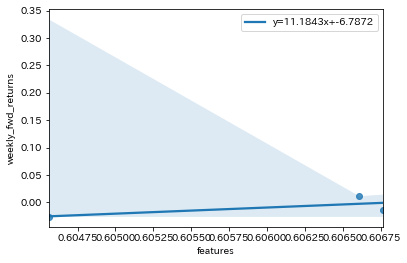

#### feature_type: keywords_features

/opt/conda/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/opt/conda/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:176: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


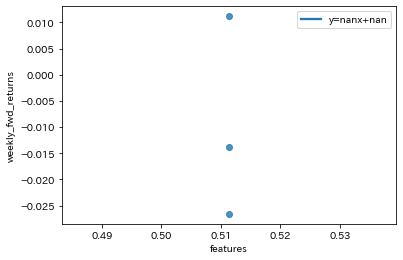

In [92]:
def display_regplot(df, x_column='features', y_column='weekly_fwd_returns'):
    # stats.linregressを用いて、単回帰直線の係数とバイアスを取得する。
    coef, bias, _, _, _ = stats.linregress(x=df[x_column], y=df[y_column])

    # seabornのregplotを用いて、単回帰直線及び、scatter sampleを表示する。
    _, ax = plt.subplots(1, 1, figsize=(6, 4))
    sns.regplot(
        x=x_column,
        y=y_column,
        data=df,
        ax=ax,
        line_kws={
            "label": "y={0:.4f}x+{1:.4f}".format(coef, bias), # 取得した係数とバイアスを用いて単項式を表示する。
        },
    )
    plt.legend()
    plt.show()

for features, feature_type in [(headline_features, 'headline_features'), (keywords_features, 'keywords_features')]:
    display_markdown(f'#### feature_type: {feature_type}', raw=True)
    df = pd.concat([features, weekly_fwd_returns], axis=1, sort=True).dropna()
    display_regplot(df=df)

<AxesSubplot:>

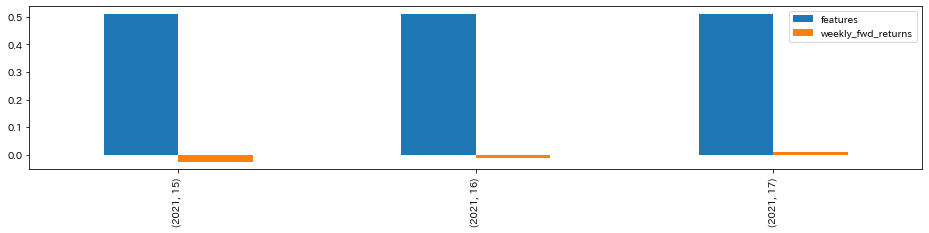

In [93]:
# barplotより、特徴量とラベル間での相互関係を確認する。
# 二つのデータを一つの軸上で単純にプロットすると値のノルムや平均、分散の違いから、相互的な動きを確認しにくい。
df.plot(kind='bar', figsize=(16, 3))

#### feature_type: headline_features

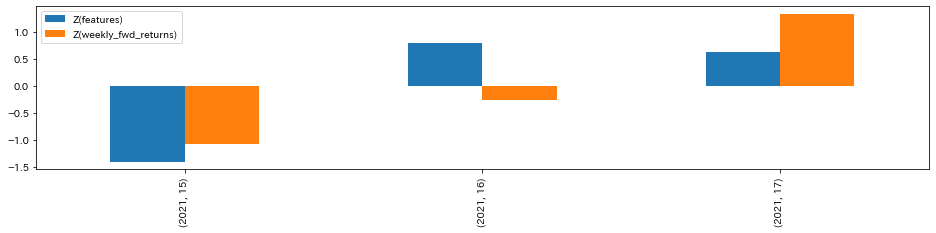

#### feature_type: keywords_features

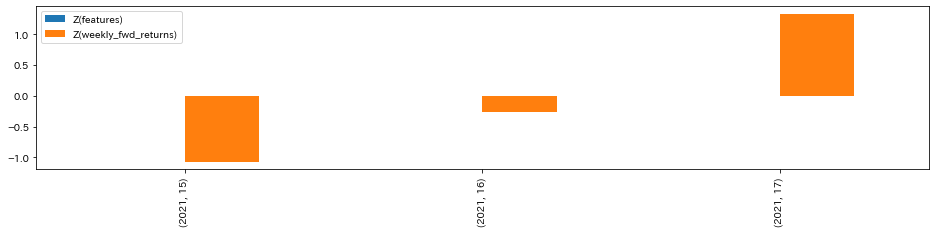

In [94]:
# ここでは、手元にあるデータを平均と分散を用いてノーマライズしたzscoreを使って相互関係可視化してみよう。
def normalize(df):
    # zscore normalizeする。
    return pd.DataFrame(stats.zscore(df), index=df.index, columns=[f'Z({column})' for column in df.columns])


def display_bar_plot(df):
    # zscore normalizeしたデータを用いてbarplotする。
    normalize(df).plot(kind='bar', figsize=(16, 3))
    plt.show()
    

for features, feature_type in [(headline_features, 'headline_features'), (keywords_features, 'keywords_features')]:
    display_markdown(f'#### feature_type: {feature_type}', raw=True)
    df = pd.concat([features, weekly_fwd_returns], axis=1, sort=True).dropna()
    display_bar_plot(df=df)